# Financial sentiment classification
**Group Name: Good Luck**

|       Name      | Email Address | Student ID|
|-----------------|---------------|-----------|
| Wenbo Shi | z5438315@ad.unsw.edu.au | z5438315 |
| Junyu Li | z5467278@ad.unsw.edu.au | z5467278 |
|Linxuan Zhong|z5470187@ad.unsw.edu.au|z5470187|
|Yang Zhang|z5503515@ad.unsw.edu.au|z5359206|
|Tong Ding|z5490086@ad.unsw.edu.au|z5490086|



# Table of Contents

#### 1. Introduction, Motivation and Problem Statement
#### 2. Data Source, Analysis and Augmentation
#### 3. Models and Methods
 - LSTM
 - GRU
 - Bert
 - FineBert

#### 4. Results
#### 5. Discussion

# 1. Introduction



### Financial sentiment analysis.

The sentiment analysis is a core task as it is one of the standard used to examine the model's performance in NLP research. In our task, we try to identify whether it shows positive, neutral or negative signals, which is, the polarity of financial news sentences. It can benefit the vast investors and participators with their decision making, by utilizing the huge amount of data online and the automation and high efficiency of ML models.

### Problem statement
**Our dataset** comes from the paper https://arxiv.org/abs/1307.5336, financial phrase bank -- 4846 financial news samples, each with negative/neutral/positive annotation.

**Our goal** is to correctly classify the financial sentences with high accuracy, using our model.

**Our implementation** focuses on: Using DA (Data Augmentation) to balance and expand the data; Designing the financial domain-specific NLP models: GRU, LSTM; Fine-tuning the LLM -- BERT, and analyse the FinBert model. (from the first paper)

### Motivation
Financial sentiment analysis is a powerful tool for monitoring economic developments in near real-time, offering significant advantages over traditional methods. This approach leverages the vast amount of data generated on social media and other digital platforms, enabling more responsive and dynamic economic analysis.

The financial sentiment analysis can help monitoring the economic developments with the advantage of:

*   Huge amount of data from social media (vs Indicators from questionaires);
*   Auto classification with efficient ML algorithms (vs Intensive manual works)


### Literature review
Through our literature review, we have conclude the following innovations aspect from the papares in Financial sentiment analysis area, which shows a banchmark of past valid researches as well as the up-to-date implementations and method in this task.

1. Good Debt or Bad Debt (2013)

 Detecting Semantic Orientations in Economic
 Developed LPS+SVM for detecting the semantic orientation of economic texts.
 Established financial phrase-bank dataset.

2. An LSTM model for Twitter Sentiment Analysis (2022)

 Presents an LSTM-based model designed for sentiment analysis of Twitter data. Handle the unique challenges posed by Twitter's informal language and short text length, achieving improved sentiment classification performance.

3. FinBERT: Financial Sentiment Analysis with Pre-trained Language Models(2019)

 FinBERT, a BERT-based language model, is tailored for financial sentiment analysis. The model is pre-trained on a large financial corpus and fine-tuned for sentiment classification tasks, achieving state-of-the-art results in financial text analysis.

4. StockEmotions: Discover Investor Emotions for Financial Sentiment Analysis and Multivariate Time Series (2023)

 The paper introduces StockEmotions, a framework for identifying investor emotions and analyzing their impact on financial sentiment and time series data. It uses advanced NLP techniques to capture the emotional tone of financial texts and correlates them with market trends.


# 2. Data Source, Analysis and Data Augmentation


Data source -- finacial phrase bank, is established by *Good Debt or Bad Debt (2013)* can be found at https://arxiv.org/abs/1307.5336. The original data have four files containing the sentences with 100% agreement, sentences with >70% agreement, sentences with >66% agreement, sentences with >50% agreement. Our data is a csv file *all_data.csv* combines all the sentences from these files, in total we have 4846 financial news sentences. Each sentence is annotated by human annotators (16 people with adequate background knowledge on financial markets) with a labeled positive, negative or neutral.

### Load the data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
file_path = '/data/all_data.csv'
data = pd.read_csv(file_path)

### Explore the data

The raw dataset has 2880 sentences in neutral class, 1363 in positve, 604 in negative. The sentence length ranges from 0 to more than 80


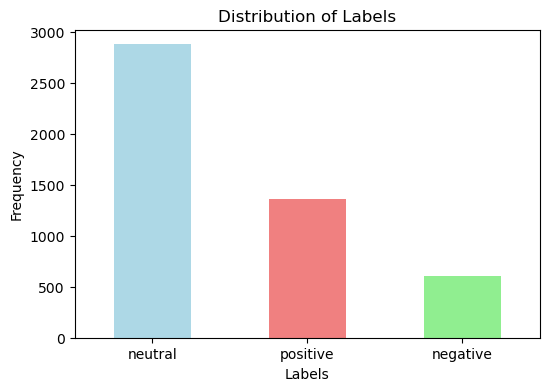

In [ ]:
# Distribution of labels
label_distribution = data['label'].value_counts()
colors = ['lightblue', 'lightcoral', 'lightgreen']
plt.figure(figsize=(6, 4))
label_distribution.plot(kind='bar', color=colors)
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

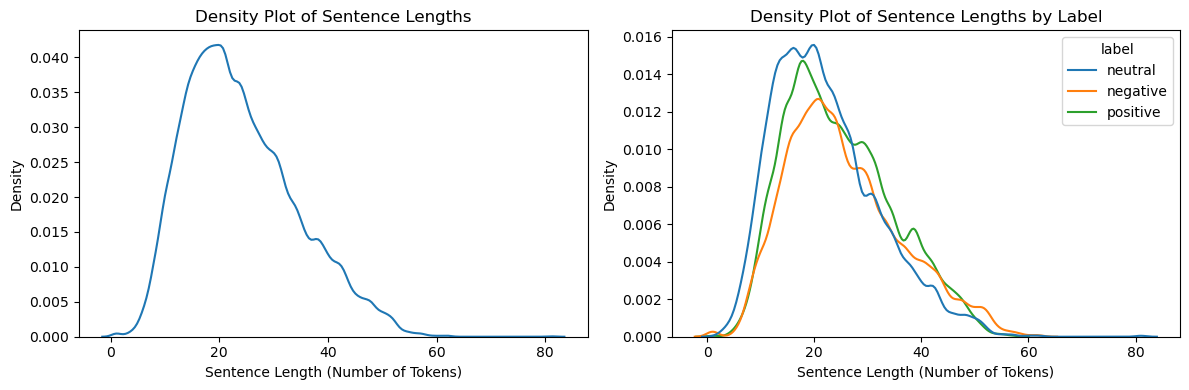

In [ ]:
# Density of sentence lengths
file_path = 'D:/COMP9444_proj/data/basic_data.csv'
data = pd.read_csv(file_path, encoding='ISO-8859-1')
data['text_length'] = data['text'].apply(lambda x: len(x.split()))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.kdeplot(data['text_length'], bw_adjust=0.5, ax=axes[0])
axes[0].set_xlabel('Sentence Length (Number of Tokens)')
axes[0].set_ylabel('Density')
axes[0].set_title('Density Plot of Sentence Lengths')
sns.kdeplot(data=data, x='text_length', hue='label', bw_adjust=0.5, ax=axes[1])
axes[1].set_xlabel('Sentence Length (Number of Tokens)')
axes[1].set_ylabel('Density')
axes[1].set_title('Density Plot of Sentence Lengths by Label')
plt.tight_layout()
plt.show()

#### Challenging aspects:
1. Inbalance between categories
2. Fewer token units in negative and positive data
3. The total amount of data is relatively small


## 2.1 Intro about Data Augmentation (DA)

Data quality is important for the accuracy and rationality of NLP tasks. As Rubbish in, rubbish out. The original dataset, the financial phrase bank, covers a collection of 4846 sentences. Since the data is imbalanced and the amount is not large, we try to implement Data Augmentation (DA) for our financial sentiment classification task. In this section, we aim to:
1.	Discuss EDA (random word insertion/substitution/swap/deletion), utilizing LLM-based embedding, and back translation methods.
2.	Implement and analyze the Pros and Cons case specifically.
3.	Renew our dataset with the augmented data with the best implementation rationale/result.


## 2.2 Empirical results of DA


EDA (Easy Data Augmentation) includes the following useful ways:



*   RI (Random Insertion)
*   SR (Synonym Replacement/Substitution)
*   RS (Random Swap)
*   RD (Random Deletion)

From the empirical results, it usually adapts to increase the accuracy of the initial training stage (with the first 20% data) in small dataset, while on average it yields 0.8% improvement with the full dataset trained.

### EDA and Back-Translation method

In our case, the word RS/RD will change our polarity of sentence in finance domain. (E.g. “Profit decrease…” (negative) -> “Profit…” (may be categorized to positive entity); or “Manager beats the market” -> “Market beats the manager” (reverse the logic)).

Thus, we consider the word RI/SR based on word-embedding similarity (Word2Vec/Glove/Fasttext), contextual word embedding (pre-trained LLM: BERT/RoBERTa), and Synonym Lexical Database (WordNet). Here, we strengthen that the word embedding represents the word as a dense vector in continuous space, while the Synonym (using WordNet Lexical Database) groups the words. The contextual word embedding is also different from word-embedding similarity, as one is dynamic embeddings and another is static.

Based on this knowledge, we implement the above methods by choosing specific available models to test on financial news sentences. The original data (retrieved from WSJ July/2024 news) and augmented data shown as follows:

 **Original text:**


---


“'Greatest Bubble' Nearing Its Peak, Says Black Swan Manager Universa's Mark Spitznagel, who has made billions from past crashes, sees last hurrah for stocks before severe reckoning”

### RI (Random Insertion) or SR (Synonym Replacement/Substitution) using Word Embedding and Synonym Lexical Database

In [ ]:
# SR with "word2vec"
aug = naw.WordEmbsAug(
  model_type = 'word2vec',
  model_path = 'GoogleNews-vectors-negative300.bin',
  action = "substitute")
augmented_text = aug.augment(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)

Original:

  'Greatest Bubble' Nearing Its Peak, Says Black Swan Manager 
  Universa's Mark Spitznagel, who has made billions from past crashes, sees last hurrah for stocks before severe reckoning
  
Augmented Text:
["' Greatest Randoms ' Nearing Most Express_Chairlift, Says offensive_tackle_Ciron Gellibrand Manager Universa ' systemâ_€_™ Mark Spitznagel, who years made billions off past crashes, sees last hurrah included industrials before severe reckoning"]


In [ ]:
# SR with "fasttext"
aug = naw.WordEmbsAug(
  model_type = 'fasttext',
  model_path = 'crawl-300d-2M.vec',
  action = "substitute")
augmented_text = aug.augment(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)

Original:

  'Greatest Bubble' Nearing Its Peak, Says Black Swan Manager 
  Universa's Mark Spitznagel, who has made billions from past crashes, sees last hurrah for stocks before severe reckoning
  
Augmented Text:
["' Wackiest Orbz ' Nearing Its Peak, Says Black Swan Manager Universa ' s Mattew Spitznagel, who has made billions froman eons crashes, sees last woo-hoo -For stocks time.Prior severe.The approacheth"]


In [ ]:
# SR with "glove"
aug = naw.WordEmbsAug(
  model_type = 'glove',
  model_path = 'glove.6B.300d.txt',
  action = "substitute")
augmented_text = aug.augment(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)

Original:

  'Greatest Bubble' Nearing Its Peak, Says Black Swan Manager 
  Universa's Mark Spitznagel, who has made billions from past crashes, sees last hurrah for stocks before severe reckoning
  
Augmented Text:
["' Greatest Bubble ' Nearing Its Peak, Says Black Swan Manager Universa ' e Mark Spitznagel, , has made aid it down occurred, turns six hurrah instead stocks before afflicted reckoning"]


In [ ]:
# RI with "BERT"
aug = naw.ContextualWordEmbsAug(
  model_path = 'bert-base-uncased',
  action = "insert")
augmented_text = aug.augment(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)

Original:

  'Greatest Bubble' Nearing Its Peak, Says Black Swan Manager 
  Universa's Mark Spitznagel, who has made billions from past crashes, sees last hurrah for stocks before severe reckoning
  
Augmented Text:
["' we greatest bubble'nearing at its peak, 2015 says the black swan manager universa's and mark spitznagel, businessman who himself has made billions from numerous past crashes, sees last good hurrah for stocks before severe cost reckoning"]


In [ ]:
# RI with "RoBERTA"
aug = naw.ContextualWordEmbsAug(
  model_path = 'roberta-base',
  action = "insert")
augmented_text = aug.augment(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)

Original:

  'Greatest Bubble' Nearing Its Peak, Says Black Swan Manager 
  Universa's Mark Spitznagel, who has made billions from past crashes, sees last hurrah for stocks before severe reckoning
  
Augmented Text:
["' Konstantino Greatest PLEASURE Bubble ' Nearing Its Peak, Says Unlawful Black Swan Manager Paul Universa ' AmeriPlan s Mark Superior Spitznagel, who has Valentin made Alliance billions from past crashes, sees Ladbroke last Norton hurrah for stocks before severe reckoning"]


In [ ]:
## SR with "WordNet"
aug = naw.SynonymAug(aug_src = 'wordnet', aug_max = 7)
augmented_text = aug.augment(text, )
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)

Original:

  'Greatest Bubble' Nearing Its Peak, Says Black Swan Manager 
  Universa's Mark Spitznagel, who has made billions from past crashes, sees last hurrah for stocks before severe reckoning
  
Augmented Text:
["' Greatest Bubble ' Nearing It Summit, Says Black Swan Manager Universa ' s Mark Spitznagel, who has made billions from preceding crashes, see last hurrah for stocks before severe figuring"]




*   Analysis

 For both substitution and insertion, both the static similarity-based word embedding (using Word2Vec/Glove/Fasttext) generates lots of noises that are meaningless and irrelevant to the text sentiment by observation, while the dynamic LLM-based embedding (BERT/RoBERTa) gives more reasonable synonym although some might deviate from original text.

 The Synonym Dictionary (using WordNet) leads to a less remarkable performance, as it by chance replace the keywords (in our case the “Greatest Bubble” that tends to negative sentiment, which we want our NLP model be able to detect), and did not enlarge the samples by meaningful synonyms.

 Excitingly, the RoBERTa model gives us the most satisfied augmented data. The words it chooses: “Securities”, “Money”, “investors”, “economic” in insertions; “market” in substitution, highly reflect the context or finance domain relevance.

### RI (Random Insertion) or SR (Synonym Replacement/Substitution) using Back-Translation

Back-Translation is another popular Data Augmentation method used in many researches in the recent days. Here we implement Facebook/Helsinki-NLP models to test the popular DA method, back-translation. The resulting text in English-OtherLanguage bidirectional translation is:

In [ ]:
# Bback-translation using "facebook/wmt19-en-de". Enlish-German
back_translation_aug = naw.BackTranslationAug(
    from_model_name = 'facebook/wmt19-en-de',
    to_model_name = 'facebook/wmt19-de-en')
back_translation_aug.augment(text)

['"Biggest bubble" nears its peak, says Mark Spitznagel of Black Swan manager Universa, who has made billions from past crashes, and sees last hurrah for stocks facing heavy reckoning']

In [ ]:
# Back translation using "Helsinki-NLP/opus-mt-en-zh". English-Chinese
back_translation_aug = naw.BackTranslationAug(
    from_model_name='Helsinki-NLP/opus-mt-en-zh',
    to_model_name='Helsinki-NLP/opus-mt-zh-en')
augmented_text = back_translation_aug.augment(text)
print("Original Text:")
print(text)
print("Augmented Text (Back Translation):")
print(augmented_text)

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/312M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/312M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/806k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/805k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.62M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/805k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/807k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.62M [00:00<?, ?B/s]

Original Text:

  'Greatest Bubble' Nearing Its Peak, Says Black Swan Manager 
  Universa's Mark Spitznagel, who has made billions from past crashes, sees last hurrah for stocks before severe reckoning
  
Augmented Text (Back Translation):
['Mark Spitznagel, the manager of the Black Swan, has earned billions of dollars from the crashes of the past.']


In [ ]:
# Use back translation augmenter with English to Chinese and back to English
back_translation_aug = naw.BackTranslationAug(
    from_model_name='Helsinki-NLP/opus-mt-en-es',
    to_model_name='Helsinki-NLP/opus-mt-es-en')
augmented_text = back_translation_aug.augment(text)
print("Original Text:")
print(text)
print("Augmented Text (Back Translation):")
print(augmented_text)

config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/312M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.44k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/312M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/826k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.59M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/826k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.59M [00:00<?, ?B/s]

Original Text:

  'Greatest Bubble' Nearing Its Peak, Says Black Swan Manager 
  Universa's Mark Spitznagel, who has made billions from past crashes, sees last hurrah for stocks before severe reckoning
  
Augmented Text (Back Translation):
['"The Biggest Bubble" near its peak, says Black Swan Universal manager Mark Spitznagel, who has made billions of past accidents, sees last hurrah for stocks before']




*   Analysis

 The advantage of back translation is that it diverse the sentence structure vividly with almost all key information maintained. It is the most human-like way of DA. We observe that English-Chinese generates a relatively short text, and English-Spanish does not change the original data much.

## 2.3 Renew dataset with Augmented Data

### Generate augmented data

In [ ]:
# Augment dataset with EDA and Back translation
import pandas as pd
import nlpaug.augmenter.word as naw

csv_file_path = 'data/all_data_utf8.csv'
# Initiate the synonym augmentation
df = pd.read_csv(csv_file_path)
aug_syn = naw.SynonymAug(
  aug_src = 'wordnet',
  aug_max = 5)
augmented_texts = []
for text in df['text']:
    augmented_text = aug_syn.augment(text)
    augmented_texts.append(augmented_text)
df['augmented_text'] = augmented_texts
augmented_texts = []
for text in df['text']:
    augmented_text = aug_syn.augment(text)
    augmented_texts.append(augmented_text)

df['augmented_text'] = augmented_texts
output_csv_file_path = 'data/augmented_data_synonym_wordnet.csv'
df.to_csv(output_csv_file_path, index=False)

In [ ]:
df = pd.read_csv(csv_file_path)
## Initiate the contextual word embeddings
aug_emb = naw.ContextualWordEmbsAug(
  model_path = 'roberta-base',
  action = "insert",
  device = 'cuda'
  )
augmented_texts = []
for text in df['text']:
    augmented_text = aug_emb.augment(text)
    augmented_texts.append(augmented_text)

df['augmented_text'] = augmented_texts
output_csv_file_path = 'path/to/your/augmented_data_embedding_roberta.csv' # change to where you want to save the data
df.to_csv(output_csv_file_path, index=False)

In [ ]:
df = pd.read_csv(csv_file_path)
# Initiate the back translation augmentation
aug_bt = naw.BackTranslationAug(
    from_model_name='facebook/wmt19-en-de',
    to_model_name='facebook/wmt19-de-en',
    device='cuda'
)
augmented_texts = []
for text in df['text']:
    augmented_text = aug_bt.augment(text)
    augmented_texts.append(augmented_text)

df['augmented_text'] = augmented_texts
output_csv_file_path = 'path/to/your/augmented_data_backtranslation.csv'
df.to_csv(output_csv_file_path, index=False)

### Validate effectiveness of DA preliminarily with a Fine-tuned DistilBERT

#### Fine-tune the DistilBERT model to output "distilbert-base-uncased-finetuned-finance-news"

In [ ]:
# Grab the pre-trained model
model = AutoModelForSequenceClassification.from_pretrained(
  model_ckpt,
  num_labels = len(label2id),
  label2id = label2id,
  id2label = id2label).to(device)

# Define a function to compute two metrics--accuracy and f1 score
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average = "weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
## Define the training arguments
# Set the Batch size, Number of epochs
batch_size = 8
num_epochs = 3
# Name and store the fine-tuned model
model_name = f"{model_ckpt}-finetuned-finance-news"
path_model = 'data/model'
# Training argument
training_args = TrainingArguments(
  output_dir = os.path.join(path_model, model_name),
  num_train_epochs = num_epochs,
  learning_rate = 2e-5,
  per_device_train_batch_size = batch_size,
  per_device_eval_batch_size = batch_size,
  weight_decay = 0.01,
  eval_strategy = "epoch",
  # Load the best model at the end of training
  load_best_model_at_end = True,
  push_to_hub = False,
  # Save model checkpoint after each epoch
  save_strategy = "epoch")

In [ ]:
# Define the trainer
trainer = Trainer(
  model = model,
  args = training_args,
  compute_metrics = compute_metrics,
  train_dataset = fins_encoded["train"],
  eval_dataset = fins_encoded["val"],
  tokenizer = tokenizer)

In [ ]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.421346,0.839175,0.837988
2,0.524200,0.490783,0.843299,0.844042
3,0.276000,0.575257,0.835052,0.834102


TrainOutput(global_step=1455, training_loss=0.3278196092323749, metrics={'train_runtime': 11210.3775, 'train_samples_per_second': 1.037, 'train_steps_per_second': 0.13, 'total_flos': 451276869488400.0, 'train_loss': 0.3278196092323749, 'epoch': 3.0})

#### Statistics training on original data

In [ ]:
preds_output = trainer.predict(fins_encoded["test"])

In [ ]:
preds_output.metrics

{'test_loss': 0.4213460087776184,
 'test_accuracy': 0.8391752577319588,
 'test_f1': 0.837987586695576,
 'test_runtime': 64.2333,
 'test_samples_per_second': 7.551,
 'test_steps_per_second': 0.95}

Text(0.5, 1.0, 'Normalized confusion matrix')

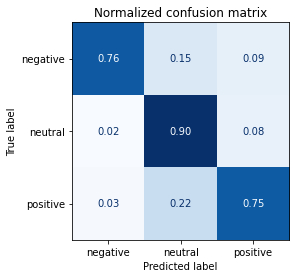

In [ ]:
# Plot the confusion matrix with predictions
cm = confusion_matrix(fins_encoded["val"]['label'], y_preds, normalize = "true")
labels = ['negative', 'neutral', 'positive']
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
disp.plot(cmap = "Blues", values_format = ".2f", colorbar = False)
plt.title("Normalized confusion matrix")

#### Test the accuracy improvement on "distilbert-base-uncased-finetuned-finance-news"

In [ ]:
# Define the function to evaluate text augmentation on model performance on test set
def evaluate_aug(aug_strategy, n, train_df, dset_val, dset_test):
  augmented_fins = []
  augmented_fins_labels = []
  for i in train_df.index:
    if aug_strategy == 'synonym':
      lst_augment = aug_syn.augment(train_df['text'].loc[i], n = n)
    for augment in lst_augment:
      augmented_fins.append(augment)
      augmented_fins_labels.append(train_df['label'].loc[i])
  augmented_fins_labels = list(zip(augmented_fins, augmented_fins_labels))
  df_augmented_fins_labels = pd.DataFrame(
    augmented_fins_labels, columns = ['text', 'label'])
  train_df_augmented = pd.concat([train_df, df_augmented_fins_labels], axis = 0)

  dset_train_augmented = Dataset.from_pandas(train_df_augmented)
  fins_augmented = DatasetDict({
    'train': dset_train_augmented,
    'val': dset_val,
    'test': dset_test})
  fins_augmented = fins_augmented.remove_columns(["__index_level_0__"])
  fins_augmented_encoded = fins_augmented.map(
    tokenize,
    batched = True,
    batch_size = None)

  # Remove the text column (model won't use it anymore)
  fins_augmented_encoded = fins_augmented_encoded.remove_columns(['text'])
  # Convert the input_ids,attention_mask columns to "torch" format.
  fins_augmented_encoded.set_format(
    "torch", columns = ["input_ids", "attention_mask", "label"])
  # Define trainer
  trainer = Trainer(
    model = model,
    args = training_args,
    compute_metrics = compute_metrics,
    train_dataset = fins_augmented_encoded["train"],
    eval_dataset = fins_augmented_encoded["val"],
    tokenizer = tokenizer)

  gc.collect()
  torch.cuda.empty_cache()
  trainer.train()

  # Use the model to predict the test set
  preds_output = trainer.predict(fins_encoded["test"])
  print(preds_output.metrics)

  # Remove all elements from the lists
  augmented_fins.clear()
  augmented_fins_labels.clear()

#### Statistics training on Augmented data

In [ ]:
# Evaluate the synonym text augmentation
score_synonym = evaluate_aug(
  aug_strategy = 'synonym',
  n = 1,
  train_df = train_df,
  dset_val = dset_val,
  dset_test = dset_test,
  # save_csv=True
)
print(score_synonym)

Map:   0%|          | 0/7752 [00:00<?, ? examples/s]

Map:   0%|          | 0/485 [00:00<?, ? examples/s]

Map:   0%|          | 0/485 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.539000,0.422500,0.830928,0.833425
2,0.210800,0.663742,0.857732,0.855790
3,0.088700,0.766338,0.851546,0.850169


{'test_loss': 0.3786386251449585, 'test_accuracy': 0.845360824742268, 'test_f1': 0.8479636309027523, 'test_runtime': 85.1371, 'test_samples_per_second': 5.697, 'test_steps_per_second': 0.716}
None


### Create new dataset

After generated the agumented data and cancatenate the original dataset with the three generated sets (from the above processes), by leverageing the aoumnt of sentences in each category (positive/neutral/negative), we obtained the new Augmented Dataset "basic_data", contains 8021 sentences.

*   Neural: 2879 * 1 = 2879 (Original)
*   Negative: 604 * 4 = 2416 (+ WordNet RI, RoBERTa RI, Back-translation)
*   Positive: 1363 *2 = 2726 (+ WordNet RI)

Mitigating the knowledge of finance professions after reading the cutting-edge research papers, we emphasize on the DA’s ability to:
1. Extend the vague mood in which the financial sentiments are always expressed; --> Use powerful model like RoBERTa
2. Retain entities’ polarity thus minimizing the risk of inversed logic; --> Choose RI from EDA
3. Linguistically diversify the structure and vocabulary of the expressions. --> Combine EDA (with different embedding models) and Back-translation augmented data


This Augmented dataset is important to the project as help us solve with the data imbalance, and enlarge it to an appropriate size, to support the model traning.

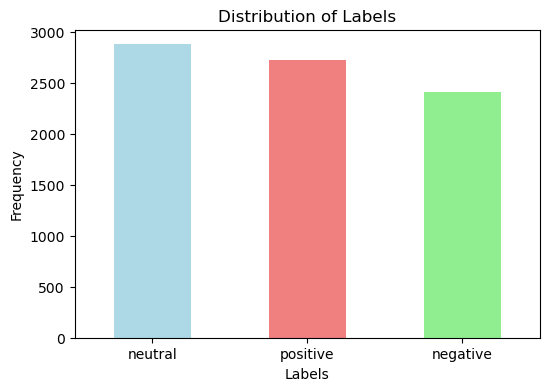

In [ ]:
# Distribution of labels
label_distribution = data['label'].value_counts()
colors = ['lightblue', 'lightcoral', 'lightgreen']
plt.figure(figsize=(6, 4))
label_distribution.plot(kind='bar', color=colors)
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()


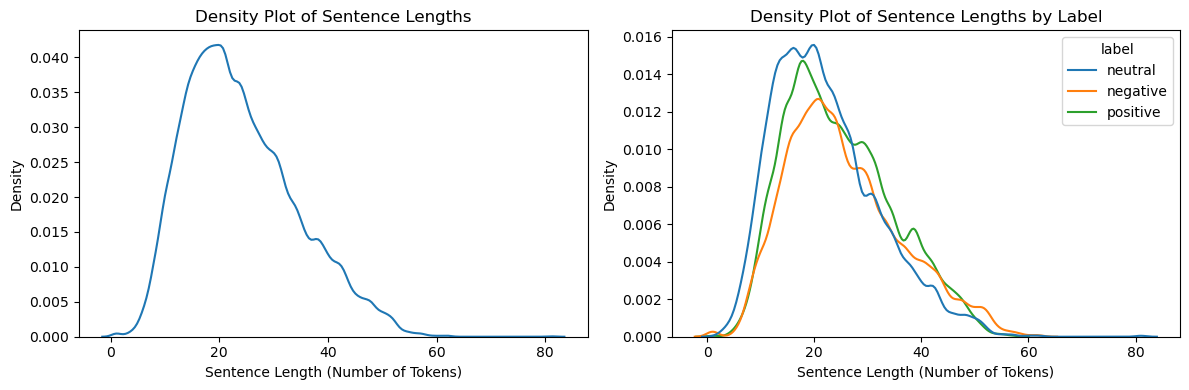

In [ ]:
# Density of Sentence Lengths
file_path = 'data/basic_data.csv'
data = pd.read_csv(file_path, encoding='ISO-8859-1')
data['text_length'] = data['text'].apply(lambda x: len(x.split()))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.kdeplot(data['text_length'], bw_adjust=0.5, ax=axes[0])
axes[0].set_xlabel('Sentence Length (Number of Tokens)')
axes[0].set_ylabel('Density')
axes[0].set_title('Density Plot of Sentence Lengths')
sns.kdeplot(data=data, x='text_length', hue='label', bw_adjust=0.5, ax=axes[1])
axes[1].set_xlabel('Sentence Length (Number of Tokens)')
axes[1].set_ylabel('Density')
axes[1].set_title('Density Plot of Sentence Lengths by Label')
plt.tight_layout()
plt.show()


# 3. Models and Methods



## Introduction


Text classification is a crucial task in natural language processing (NLP), where the goal is to assign predefined categories to textual data. Various models have been developed to tackle this problem, each with its unique strengths and capabilities. In our project, we explore and compare four distinct models for text classification:

1. **LSTM (Long Short-Term Memory):**
   - LSTM networks are a type of recurrent neural network (RNN) capable of learning long-term dependencies. In this pr

2. **GRU (Gated Recurrent Unit):**
   - GRU networks, like LSTMs, are designed to handle sequential data. They are a simplified version of LSTMs with fewer parameters, which can lead to faster training times while maintaining similar performance levels. GRUs are effective in capturing temporal dependencies in text data.

3. **BERT (Bidirectional Encoder Representations from Transformers):**
   - BERT is a powerful transformer-based model that has revolutionized NLP. It pre-trains deep bidirectional representations by jointly conditioning on both left and right context in all layers. This allows BERT to achieve state-of-the-art performance on various NLP tasks, including text classification, by leveraging rich contextual information.

4. **FinBERT:**
   - FinBERT is a variant of BERT specifically pre-trained on financial texts. It adapts the general language understanding of BERT to the nuances of financial language, making it particularly effective for tasks like sentiment analysis and classification in the financial domain.

By comparing these four models, we aim to identify their strengths and weaknesses in the context of text classification. Our experiments will provide insights into which models perform best under different conditions and datasets, helping to guide future applications and developments in NLP.


## Analysis method

Due to comparing the accuracy of different models, we will use the confusion matrix and precision, accuracy, F1 score, recall, and weighted average metrics to evaluate the performance of each model.

### 1. Precision

- **Definition**: The ratio of true positive instances among the instances predicted as positive.
- **Formula**:
  $$
  \text{Precision} = \frac{TP}{TP + FP}
  $$
  - \( TP \): True Positive
  - \( FP \): False Positive

- **Meaning**:
  - Precision measures how many of the samples predicted as positive are actually positive. High precision indicates that the model makes few mistakes when predicting positive cases.
  - In certain applications, such as spam filtering, precision is very important because we want to minimize the number of legitimate emails incorrectly classified as spam.

### 2. Accuracy

- **Definition**: The ratio of correctly predicted samples to the total number of samples.
- **Formula**:
  $$
  \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
  $$
  - \( TN \): True Negative
  - \( FN \): False Negative

- **Meaning**:
  - Accuracy is the most straightforward performance measure, indicating the overall correctness of the model's predictions.
  - It is suitable for situations with balanced class distribution, but it can be misleading in cases with class imbalance.

### 3. F1 Score

- **Definition**: The harmonic mean of precision and recall.
- **Formula**:
  $$
  \text{F1} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
  $$

- **Meaning**:
  - The F1 Score combines precision and recall, making it suitable for situations with imbalanced classes.
  - It provides an overall performance evaluation, particularly useful when a balance between precision and recall is needed.

### 4. Recall

- **Definition**: The ratio of true positive instances among the actual positive instances.
- **Formula**:
  $$
  \text{Recall} = \frac{TP}{TP + FN}
  $$
  - \( TP \): True Positive
  - \( FN \): False Negative

- **Meaning**:
  - Recall measures the model's ability to capture positive instances. High recall indicates that the model can find more positive instances.
  - In certain applications, such as disease detection, recall is very important because we want to minimize the number of missed detections.

### 5. Weighted Average Metrics

- **Definition**: The weighted average of metrics considering the number of samples in each class, used for calculating precision, recall, and F1 score.
- **Formula**:
  $$
  \text{Weighted Metric} = \frac{\sum_{i=1}^{n} w_i \times \text{Metric}_i}{\sum_{i=1}^{n} w_i}
  $$

- **Meaning**:
  - Weighted average metrics consider the differences in the number of samples for each class, providing a fairer performance evaluation.
  - They are especially useful for datasets with imbalanced classes, avoiding the excessive influence of minority classes on the overall evaluation.


## LSTM

Long Short-Term Memory (LSTM) is a recurrent neural network (RNN) architecture in deep learning designed to address vanishing or exploding gradients in traditional RNNs. LSTM introduces memory cells that retain information over long sequences, featuring three main components: an input gate, a forget gate, and an output gate.
- **Input Gate**: Determines what new information to store in the cell state. It consists of two components:
  1. **Sigmoid Function**: Decides which values to update.
  2. **Tanh Function**: Generates a vector of new candidate values to add to the cell state.

- **Forget Gate**: Decides which information to discard from the cell state, using the current input and previous hidden state to generate values between 0 (discard) and 1 (keep).

- **Output Gate**: Determines the next hidden state by filtering information from the updated cell state.




In [ ]:
import numpy as np
import pandas as pd
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Input,Embedding,GlobalMaxPooling1D
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import matplotlib.pyplot as plt


### Imoport data

In [ ]:
train_df=pd.read_csv("/content/drive/MyDrive/comp9444/data/all_data_new_basedonsynonym.csv", encoding='unicode_escape',names=['Sentiment', 'Sentence'])
# train_df=pd.read_csv("../all-data.csv", encoding='unicode_escape',names=['Sentiment', 'Sentence'])



**Using NLTK Library:** Utilizes features from the NLTK (Natural Language Toolkit) library.

**Using Regular Expressions:** Regular expressions are used for text cleaning, including:
  - Removing URLs, @mentions, #hashtags, and $tags.
  - Removing non-ASCII characters.
  - Removing consecutive punctuation marks (e.g., commas and periods).
  - Retaining only letters and spaces, removing all other characters.
  - Merging multiple spaces into one.

**Text Normalization:**
  - Converting text to lowercase to ensure consistency.
  - Cleaning text using regular expressions.

**Text Tokenization:** Uses NLTK’s `word_tokenize` to split text into words (tokens), which helps in word-by-word processing.

**Removing Stopwords:** Removes common meaningless words (e.g., "the", "is") from the text, which do not contribute significantly to the main meaning of the text.

**Stemming:** Uses the Porter Stemmer to reduce words to their root form, which helps in reducing word variations and improving the generalization ability of models.


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
stemmer = PorterStemmer()
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|@\S+|#[A-Za-z0-9]+|\$[A-Za-z0-9]+', '', text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    text = re.sub(r'\,{2,}', '', text)
    text = re.sub(r'\.{2,}', '', text)
    text = re.sub(r'[^a-zA-Z\s\']', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    tokens = word_tokenize(text)
    stopwords_set = set(stopwords.words('english'))
    tokens = [stemmer.stem(word) for word in tokens if word not in stopwords_set]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

def preprocess_text2(text):
    text = text.lower()
    text = re.sub(r'\,{2,}', '', text)
    text = re.sub(r'\.{2,}', '', text)
    text = re.sub(r'[^a-zA-Z\s.,\']', '', text)
    tokens = word_tokenize(text)
    stopwords_set = set(stopwords.words('english'))
    tokens = [stemmer.stem(word) for word in tokens if word not in stopwords_set]
    return tokens

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|@\S+|#[A-Za-z0-9]+|\$[A-Za-z0-9]+', '', text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    text = re.sub(r'\.{2,}', '', text)
    text = re.sub(r'\,{2,}', '', text)
    text = re.sub(r'[^a-zA-Z\s.,\']', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = ''.join(text)
    return text

def clean_text2(text):
    if isinstance(text, float):
        return ""
    text = text.lower()
    text = re.sub(r'http\S+|@\S+|#[A-Za-z0-9]+|\$[A-Za-z0-9]+', '', text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    text = re.sub(r'\.{2,}', '', text)
    text = re.sub(r'\,{2,}', '', text)
    text = re.sub(r'[^a-zA-Z\s.,\']', '', text)
    text = re.sub(r'\s+', '', text)
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#### Data preprocessing

In [ ]:
clean_data=lambda text:clean_text(text)
train_df["Sentence"]=train_df["Sentence"].apply(clean_data)

In [ ]:
preprocess_data=lambda text:preprocess_text(text)
train_df["text_prepro"]=train_df["Sentence"].apply(preprocess_data)

In [ ]:
X=train_df.drop(["Sentence","Sentiment"],axis=1)
y=train_df["Sentiment"]

In [ ]:
tokenized_documents=[preprocess_text2(doc) for doc in X["text_prepro"]]

#### Applying the Word2vec model

In [ ]:
# Generating word vectors: This code uses the `Word2Vec` model
# to train on the input tokenized documents and generate word vectors of the specified dimension.
ukuran_vektor=100
word2vec_model = Word2Vec(sentences=tokenized_documents,
                          min_count=1, vector_size=ukuran_vektor,sg=1)

In [ ]:
print(word2vec_model)

Word2Vec<vocab=7742, vector_size=100, alpha=0.025>


- Extracting the word list: Extracts all words from the trained Word2Vec model, sorted by their frequency of occurrence.
- Printing the first 50 words and their indices

In [ ]:
all_words =word2vec_model.wv.index_to_key


- Preprocess text data: Further processes the preprocessed text data in the DataFrame, converting each document into a list of words.
- Generate index sequences: Uses the `Word2Vec` model to convert each word into its corresponding index, generating sequences of these indices.

In [ ]:
sequences = [[word2vec_model.wv.key_to_index[word] for word in text]
             for text in [preprocess_text2(doc) for doc in X['text_prepro']]]

- Padding index sequences to a fixed length: Using the pad_sequences function, variable-length index sequences are padded (or truncated) to a fixed length.

In [ ]:
max_length =train_df['text_prepro'].apply(lambda x: len(x.split())).max()

In [ ]:
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

- This code snippet encodes the label data using LabelEncoder, converting categorical labels into numerical form.
- In this example, LabelEncoder encodes the category labels "positive", "neutra", and "lnegative" as 0, 1, and 2, respectively.

In [ ]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

- This code uses the `train_test_split` function to divide the feature data and label data into training and validation sets.


In [ ]:
X_train,X_val,y_train,y_val=train_test_split(padded_sequences,y,
                    test_size=0.3,random_state=42, stratify=y)

#### Appply the emdedding matrix
- This code creates an `embedding matrix` containing word vectors extracted from a `Word2Vec` model. This embedding matrix can be used in the embedding layer of a neural network, allowing the use of pretrained word vectors to represent words during training.

In [ ]:
embedding_matrix = np.zeros((len(word2vec_model.wv.key_to_index) + 1, word2vec_model.vector_size))
for word, i in word2vec_model.wv.key_to_index.items():
    embedding_vector = word2vec_model.wv[word]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
jumlah_kelas=len(np.unique(y))

### Design the LSTM model

1. **Input layer:** Defines the input shape of the model as sequences of maximum length.
2. **Embedding layer:** Converts word indices to corresponding word vectors using the embedding matrix.
3. **LSTM layer:** Processes sequential data with Long Short-Term Memory units.
4. **Global Max Pooling layer:** Applies global max pooling to reduce the dimensionality of the data.
5. **Dense layer:** Fully connected layer with 512 neurons using ReLU activation.
6. **Dropout layer:** Prevents overfitting by randomly dropping 50% of the neurons during training.
7. **Output layer:** Fully connected layer with `jumlah_kelas` neurons using softmax activation for multi-class classification.



In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Input,Embedding,GlobalMaxPooling1D
from tensorflow.keras.regularizers import l2

model = Sequential()
model.add(Input(shape=(max_length,)))
model.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1],
                  trainable=False))
model.add(LSTM(ukuran_vektor, return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(GlobalMaxPooling1D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(jumlah_kelas, activation='softmax'))


#### Compile model
- **Optimizer:** Uses the defined Adam optimizer.
- **Loss function:** Specifies the loss function as sparse categorical cross-entropy, suitable for multi-class classification problems with integer labels.
- **Metrics:** Specifies accuracy as the metric to monitor during training and evaluation.


In [ ]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',
                                                      metrics=['accuracy'])

- **EarlyStopping strategy:** Uses the EarlyStopping strategy to prevent overfitting by monitoring the validation loss and stopping training when it no longer improves.


In [ ]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15,
                                     restore_best_weights=True)

#### Run the model
- **Train the model:** Trains the model using the training data and labels, specified number of epochs, batch size, validation data, and callbacks.
- **Save training history:** Stores the history of training and validation loss, accuracy, and other metrics for analysis.


In [ ]:
history = model.fit(X_train, y_train, epochs=1000, batch_size=128,
                    validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.3593 - loss: 2.3042 - val_accuracy: 0.3590 - val_loss: 1.4943
Epoch 2/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3707 - loss: 1.3774 - val_accuracy: 0.4030 - val_loss: 1.1682
Epoch 3/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3968 - loss: 1.1425 - val_accuracy: 0.3590 - val_loss: 1.1113
Epoch 4/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3958 - loss: 1.1025 - val_accuracy: 0.4678 - val_loss: 1.0418
Epoch 5/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4669 - loss: 1.0421 - val_accuracy: 0.4803 - val_loss: 1.0195
Epoch 6/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4832 - loss: 1.0203 - val_accuracy: 0.4923 - val_loss: 1.0092
Epoch 7/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4910 - loss: 1.0125 - val_accuracy: 0.4894 - val_loss: 1.0162
Epoch 8/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4718 - loss: 1.0185 - val_accuracy: 0

### Output
- **Loss & Accuracy:** Print out the loss and the accuracy after the training.



In [ ]:
loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f'loss: {loss:.2f}')
print(f'Accuracy: {accuracy*100:.2f}%')

loss: 0.85
Accuracy: 65.85%


In [ ]:
print("Konfigurasi Lapisan Embedding:")
print(model.layers[0].get_config())

Konfigurasi Lapisan Embedding:
{'name': 'embedding', 'trainable': False, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'input_dim': 7743, 'output_dim': 100, 'embeddings_initializer': {'module': 'keras.initializers', 'class_name': 'RandomUniform', 'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}, 'registered_name': None}, 'embeddings_regularizer': None, 'activity_regularizer': None, 'embeddings_constraint': None, 'mask_zero': False}


In [ ]:
print("Bobot Lapisan Embedding:")
print(model.layers[0].get_weights()[0])

Bobot Lapisan Embedding:
[[-0.03959677 -0.047224   -0.02380951 ... -0.04581099  0.03005746
   0.04630662]
 [-0.00444561  0.03393565 -0.02071105 ... -0.04905909  0.01404786
  -0.01354532]
 [-0.03411283  0.01715631 -0.01122431 ... -0.01671761 -0.0434383
  -0.03715217]
 ...
 [ 0.03506783  0.00407441 -0.00763954 ... -0.0486614  -0.03605776
  -0.0255087 ]
 [ 0.04898996 -0.02332547 -0.03102365 ... -0.0165454   0.00655656
   0.01666185]
 [ 0.04127786  0.00988311 -0.01708325 ... -0.04156803  0.02744162
   0.01459515]]


#### Visualise the model loss
We may observe that before 60 epochs, the loss and validation loss decrease very quickly. However, after 60 epochs, the validation loss starts to increase. To prevent overfitting, we used EarlyStopping to halt the training process when the validation loss stops improving.


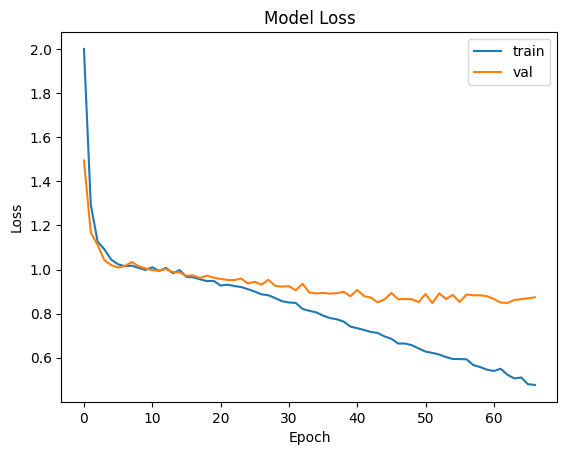

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Visulize the training and validation accuracy
This code visualizes the model's performance during training by plotting the training and validation accuracy curves over epochs. This helps to intuitively observe whether the model is overfitting, such as after 60 epochs the training accuracy continues to increase while the validation accuracy decreases.


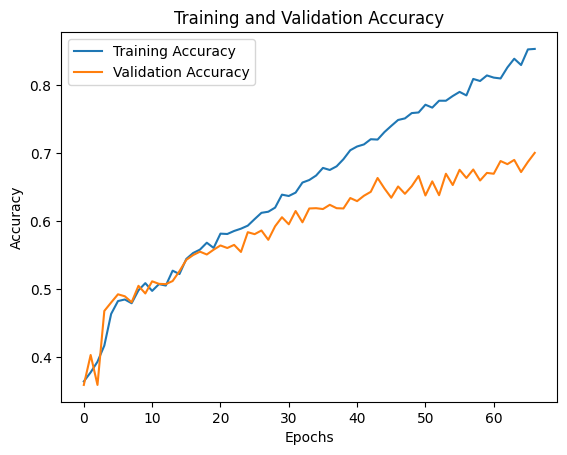

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 41, 100)             │         774,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 41, 100)             │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 100)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          51,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,175,255 (4.48 MB)

 Trainable params: 133,651 (522.07 KB)

 Non-trainable params: 774,300 (2.95 MB)

 Optimizer params: 267,304 (1.02 MB)

#### Model Performance Analysis

- **The model performs well in recognizing negative and neutral samples but is weaker in recognizing positive samples.**
- **The overall accuracy is 67%, indicating that further optimization of the model could improve performance.**
- **The macro average and weighted average scores are close to the overall accuracy, suggesting that the model's performance is relatively balanced across all classes.**



In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
target_names=np.unique((label_encoder.inverse_transform(y)))
report = classification_report(y_val, y_pred_classes,target_names=target_names)
print("Classification Report:")
print(report)

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Classification Report:
              precision    recall  f1-score   support

    negative       0.73      0.78      0.75       725
     neutral       0.65      0.62      0.64       864
    positive       0.60      0.59      0.59       818

    accuracy                           0.66      2407
   macro avg       0.66      0.66      0.66      2407
weighted avg       0.66      0.66      0.66      2407



### Confusion Matrix Analysis

The confusion matrix provides a detailed breakdown of the model's classification performance on the validation set.

### Overview
- **Rows (True Label):** Represent the actual labels.
- **Columns (Predicted Label):** Represent the predicted labels by the model.
- **Color Intensity:** Indicates the count, with darker colors representing higher counts.

### Detailed Analysis

1. **Negative Category**
   - **True Negatives (TN):** 489 negative samples correctly classified as negative.
   - **False Positives (FP) as Neutral:** 136 negative samples misclassified as neutral.
   - **False Positives (FP) as Positive:** 100 negative samples misclassified as positive.

2. **Neutral Category**
   - **True Positives (TP):** 606 neutral samples correctly classified as neutral.
   - **False Negatives (FN) as Negative:** 123 neutral samples misclassified as negative.
   - **False Positives (FP) as Positive:** 135 neutral samples misclassified as positive.

3. **Positive Category**
   - **True Positives (TP):** 367 positive samples correctly classified as positive.
   - **False Negatives (FN) as Negative:** 180 positive samples misclassified as negative.
   - **False Positives (FP) as Neutral:** 271 positive samples misclassified as neutral.

#### Improvement Suggestions

- **Enhance Positive Sample Classification:**
  - Try add more layers in the model
  - Using bi_lstm instead of lstm layer
  - Using Glove instead of word2vec
  - Add attention mechanism
  - Add batch normalization layer


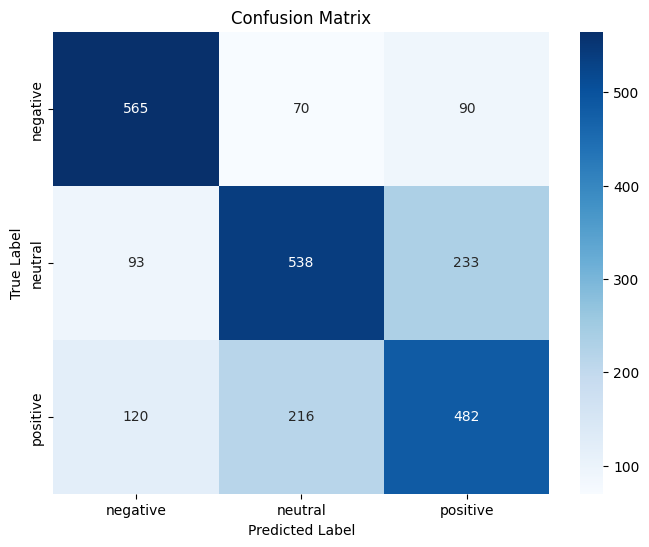

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_val, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.save("model.h5")
word2vec_model.save("word2vec_model.model")
train_df.to_csv("train_data.csv", index=False)

This way we just tried the Tokenizer + word embedding + LSTM

In [ ]:
import pandas as pd

# Read CSV file
file_path = '/content/drive/MyDrive/comp9444/data/all_data_new_basedonsynonym.csv'
data = pd.read_csv(file_path, encoding='ISO-8859-1', header=None, names=['label', 'sentence'])

# View the number of rows and first few rows of data


### Data preprocessing

1. **Label Encoding:**
   - **Method:** Mapping textual labels to numerical codes.
   - **Details:** Defines a label map to convert textual labels into numerical codes. Filters the data to include only rows with labels defined in the `label_map`. Maps the textual labels to numerical labels.

2. **Dataset Splitting:**
   - **Method:** Splitting the data into training and testing sets.
   - **Details:** Uses `train_test_split` to divide the dataset into training (80%) and testing (20%) sets, maintaining the class distribution (`stratify=y`). Extracts text data (`X`) and labels (`y`) and then splits them accordingly.

3. **Text Preprocessing:**
   - **Method:** Tokenizing and converting text to sequences.
   - **Details:** Initializes a `Tokenizer` with a vocabulary limit of 5000 words. Fits the `Tokenizer` on the training text data and converts both training and testing text data into sequences, where each word is represented by an integer.

4. **Sequence Length Distribution Statistics:**
   - **Method:** Analyzing sequence length.
   - **Details:** Computes the length of each sequence in the training set. Prints statistical information about the sequence lengths to determine an appropriate padding length.

5. **Sequence Padding:**
   - **Method:** Padding sequences to a uniform length.
   - **Details:** Pads the sequences to a fixed length (e.g., 70) to ensure consistency across all input data.

6. **One-Hot Encoding of Labels:**
   - **Method:** Converting labels to one-hot encoded format.
   - **Details:** Uses `to_categorical` to convert numerical labels into one-hot encoded labels, suitable for multi-class classification in neural networks.


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Tag encoding
label_map = {'positive': 0, 'negative': 1, 'neutral': 2}
# Only keep the tags in the tag column
data = data[data['label'].isin(label_map.keys())]
data['label'] = data['label'].map(label_map)

# Random data splitting
X = data['sentence'].values
y = data['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)
print(X_train[:2], y_train[:2])

# Text preprocessing
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Statistical sequence length distribution (for determining the length of padding sequences)
seq_lengths = [len(seq) for seq in X_train_seq]
print(pd.Series(seq_lengths).describe())

# padding sequence
max_seq_len = 70
X_train_pad = pad_sequences(X_train_seq, maxlen=max_seq_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_seq_len)
print(X_train_pad[:2])

# Convert tags to one-hot encoding
y_train = to_categorical(y_train, num_classes=len(label_map))
y_test = to_categorical(y_test, num_classes=len(label_map))
print(y_train[:10])


['`` Capital expenditure on energy efficiency has unfortunately fallen along with the decline in the economy .'
 'Jussi Pesonen , member of the Sampo Board since 2006 , will renounce his seat in Sampo Board .'] [1 2]
count    6416.000000
mean       21.602400
std         9.525195
min         1.000000
25%        14.000000
50%        20.000000
75%        28.000000
max        66.000000
dtype: float64
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0  118
  3033   12  302  553   25 3034 3035 1762   22    1 1358    3    1 1635]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0  

### Design the LSTM model

1. **Input layer:** Defines the input shape of the model as sequences of maximum length.
2. **Embedding layer:** Converts word indices to corresponding word vectors using an embedding matrix.
3. **Bidirectional LSTM layer:** Processes sequential data with Bidirectional Long Short-Term Memory units, including L2 regularization and dropout.
4. **Additive Attention layer:** Focuses on relevant parts of the sequence to improve the model's attention mechanism.
5. **Global Average Pooling layer:** Reduces the dimensionality of the output by applying global average pooling.
6. **Batch Normalization layer:** Regularizes the output and accelerates convergence during training.
7. **Dense layer:** Fully connected layer with 128 neurons using ReLU activation and L2 regularization.
8. **Dropout layer:** Prevents overfitting by randomly dropping 50% of the neurons during training.
9. **Output layer:** Fully connected layer with `len(label_map)` neurons using softmax activation for multi-class classification.



In [ ]:
# Import necessary modules from TensorFlow Keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, Attention, GlobalAveragePooling1D, AdditiveAttention, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Define the input layer with the maximum sequence length
inputs = Input(shape=(max_seq_len,))

# Add an embedding layer to convert word indices to dense vectors of fixed size
embedding = Embedding(input_dim=5000, output_dim=128)(inputs)

# Add a bidirectional LSTM layer with L2 regularization and dropout
bi_lstm = Bidirectional(LSTM(units=128,
                             return_sequences=True,
                             kernel_regularizer=l2(0.01),
                             recurrent_regularizer=l2(0.01),
                             dropout=0.2,
                             recurrent_dropout=0.2))(embedding)

# Add an additive attention layer to focus on relevant parts of the sequence
attention = AdditiveAttention()([bi_lstm, bi_lstm])

# Apply global average pooling to reduce the dimensionality of the output
global_avg_pool = GlobalAveragePooling1D()(attention)

# Add batch normalization for regularization
batch_norm = BatchNormalization()(global_avg_pool)

# Add a dense layer with ReLU activation and L2 regularization
dense = Dense(units=128, activation='relu', kernel_regularizer=l2(0.01))(batch_norm)

# Add dropout for further regularization to prevent overfitting
dropout = Dropout(rate=0.5)(dense)

# Add the output layer with softmax activation for multi-class classification
outputs = Dense(units=len(label_map), activation='softmax')(dropout)

# Create the model by specifying the inputs and outputs
model = Model(inputs=inputs, outputs=outputs)

# Compile the model with Adam optimizer, categorical cross-entropy loss, and accuracy metric
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define early stopping to monitor validation loss and stop training early if it doesn't improve
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=3,
                               restore_best_weights=True)

# Train the model with the training data, using a validation split and early stopping
history = model.fit(X_train_pad, y_train,
                    epochs=32,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[early_stopping])


Epoch 1/32
161/161 ━━━━━━━━━━━━━━━━━━━━ 28s 140ms/step - accuracy: 0.4612 - loss: 5.4206 - val_accuracy: 0.5016 - val_loss: 1.6022
Epoch 2/32
161/161 ━━━━━━━━━━━━━━━━━━━━ 22s 136ms/step - accuracy: 0.8104 - loss: 0.9415 - val_accuracy: 0.7671 - val_loss: 0.9219
Epoch 3/32
161/161 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - accuracy: 0.9152 - loss: 0.3949 - val_accuracy: 0.8170 - val_loss: 0.6173
Epoch 4/32
161/161 ━━━━━━━━━━━━━━━━━━━━ 22s 136ms/step - accuracy: 0.9452 - loss: 0.2733 - val_accuracy: 0.8107 - val_loss: 0.5672
Epoch 5/32
161/161 ━━━━━━━━━━━━━━━━━━━━ 22s 136ms/step - accuracy: 0.9556 - loss: 0.2165 - val_accuracy: 0.8380 - val_loss: 0.5315
Epoch 6/32
161/161 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - accuracy: 0.9700 - loss: 0.1784 - val_accuracy: 0.8263 - val_loss: 0.6633
Epoch 7/32
161/161 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - accuracy: 0.9729 - loss: 0.1517 - val_accuracy: 0.8419 - val_loss: 0.6531
Epoch 8/32
161/161 ━━━━━━━━━━━━━━━━━━━━ 22s 137ms/step - accuracy: 0.9814 - loss: 0

In [ ]:
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 70)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 70, 128)        │        640,000 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 70, 256)        │        263,168 │ embedding_1[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ additive_attention        │ (None, 70, 256)        │            256 │ bidirectional[0][0],   │
│ (AdditiveAttention)       │                        │                │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 256)            │              0 │ additive_attention[0]… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256)            │          1,024 │ global_average_poolin… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │         32,896 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 3)              │            387 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,812,171 (10.73 MB)

 Trainable params: 937,219 (3.58 MB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 1,874,440 (7.15 MB)

According to the early stopping, we find that at epoch 6 the model will stop. It is mainly because that training loss is still decresing and validation is increasing.

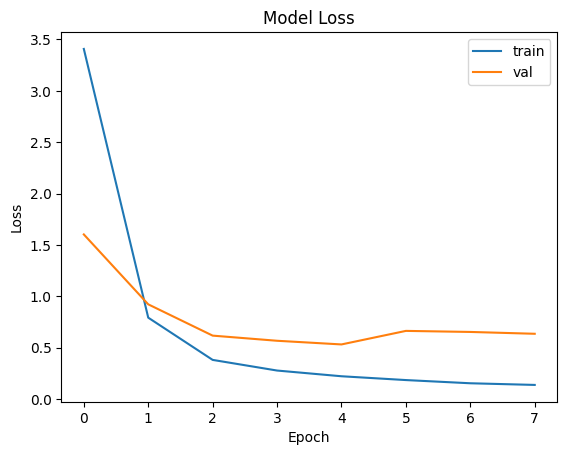

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model Evaluation Steps

- **Evaluate the model's accuracy on the test set:** Use `model.evaluate` to calculate the loss and accuracy on the test set.
- **Generate predictions:** Use the test set data to make predictions and obtain the predicted class for each sample.
- **Calculate and output evaluation metrics:** Includes accuracy, classification report (precision, recall, F1 score)(We just mentioned before).
- **Plot the confusion matrix:** Display the relationship between predicted and actual values for each class through the confusion matrix, visually presenting the model's classification performance.


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8392 - loss: 0.5553
Test Accuracy: 0.83
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
Accuracy-Score: 0.8283198826118855
              precision    recall  f1-score   support

    positive       0.82      0.86      0.84       545
    negative       0.89      0.76      0.82       242
     neutral       0.82      0.83      0.82       576

    accuracy                           0.83      1363
   macro avg       0.84      0.82      0.83      1363
weighted avg       0.83      0.83      0.83      1363



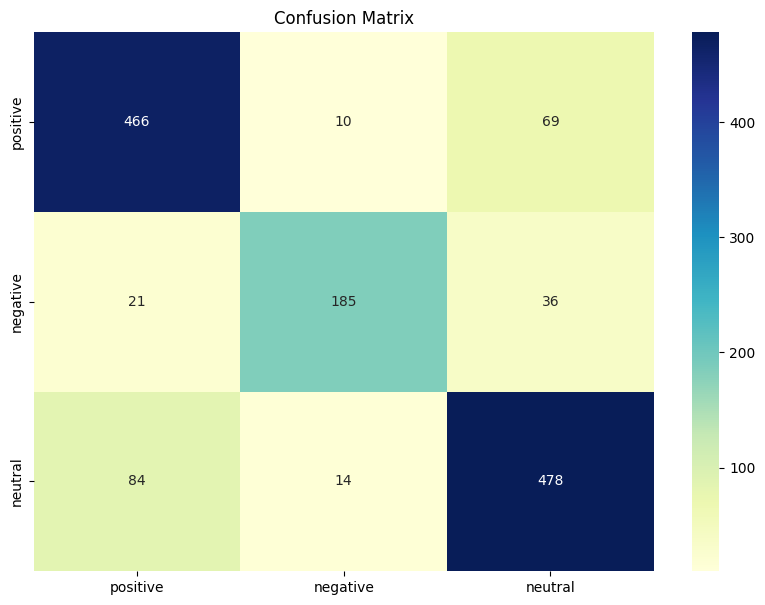

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluation model
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

# predict
y_pred_prob = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Output evaluation metrics
print(f'Accuracy-Score: {accuracy_score(y_test_labels, y_pred)}')
print(classification_report(y_test_labels, y_pred,
                            target_names=label_map.keys(),
                            zero_division=0
                            ))

# confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=label_map.keys(), index=label_map.keys())
plt.figure(figsize=(10, 7))
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix')
plt.show()


## GRU (Gate Recurrent Unit)

---
---
### Introduction

Solving the vanishing gradient problem of standard RNNs

---
`reset gate`: The reset gate determines how to combine new input information with previous memory (degree of influence).

When the reset gate is close to 0, it indicates that you want to ignore the hidden state of the previous time step.

`update gate`: The update gate defines the amount of previous memory saved to the current time step (how much information is inherited).

When the update gate is close to 1, it means that most of the hidden state of the previous time step is retained.

---
Standard `RNN` model: Set reset gate to 1 and update gate to 0.

---
These two gating mechanisms can preserve information in long-term sequences and will not be cleared over time or removed as irrelevant to predictions.


---
---



### Differences from LSTM

|  | GRU | LSTM |
|------|------|------|
| Number of Gates | Has three gates (input gate, forget gate, and output gate) | Has two gates (reset gate and update gate) |
| Cell State | Maintains a separate cell state in addition to the hidden state | Maintains a separate cell state in addition to the hidden state |
| Complexity | More complex due to its three gates and separate cell state | Simpler architecture with fewer gates and no separate cell state, potentially faster to train |
| Memory Utilization | Can explicitly control memory with the cell state, allowing the network to decide what to keep and what to discard | Uses a combined hidden state to store information, which can be more efficient for some tasks but less flexible than LSTM |
| Reset Mechanism | Uses forget gate to decide what information to discard from the cell state | Uses reset gate to reset the hidden state, controlling the amount of previous information to forget |
| Update Mechanism | Uses input gate to determine how much new information to add to the cell state | Uses update gate to control how much of the hidden state to update with new information |
| Output Calculation | The output is a combination of the cell state and hidden state influenced by the output gate | The output is directly the updated hidden state |
| Parameter Efficiency | Generally has more parameters due to the three gates and separate cell state | Usually has fewer parameters, making it more parameter-efficient |
| Training Speed | May train slower due to its more complex structure | Typically trains faster because of its simpler architecture |
| Performance | Often performs better on tasks that require learning long-term dependencies due to its more flexible memory control | Can perform equally well or better on certain tasks, particularly where the long-term dependencies are not as prominent |
| Gradient Flow | More gates and cell state can help in better gradient flow over long sequences, mitigating vanishing gradient issues | Still effective in mitigating vanishing gradient problems but with a simpler mechanism |


---
---
### GRU Structure

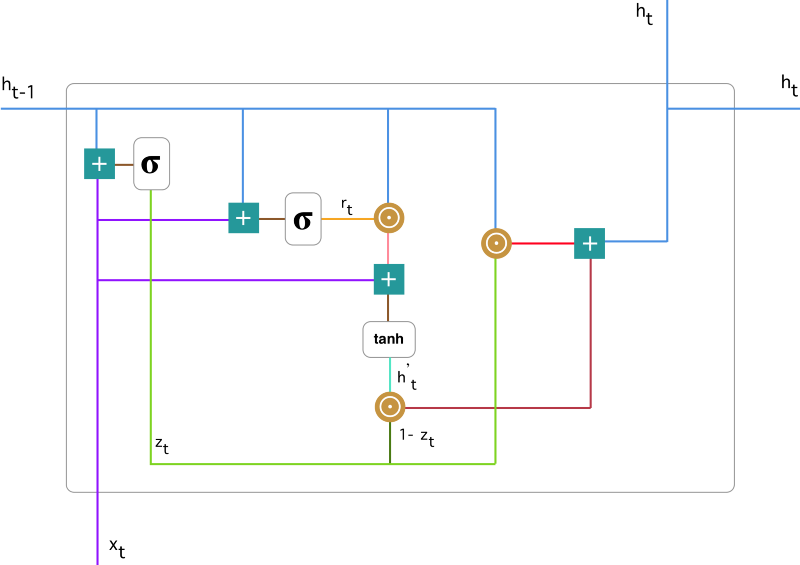

In [ ]:
from PIL import Image

with open('../static/GRU1.png', 'rb') as file:
    img = Image.open(file)
    img.load()
img

---
`The Update Gate`

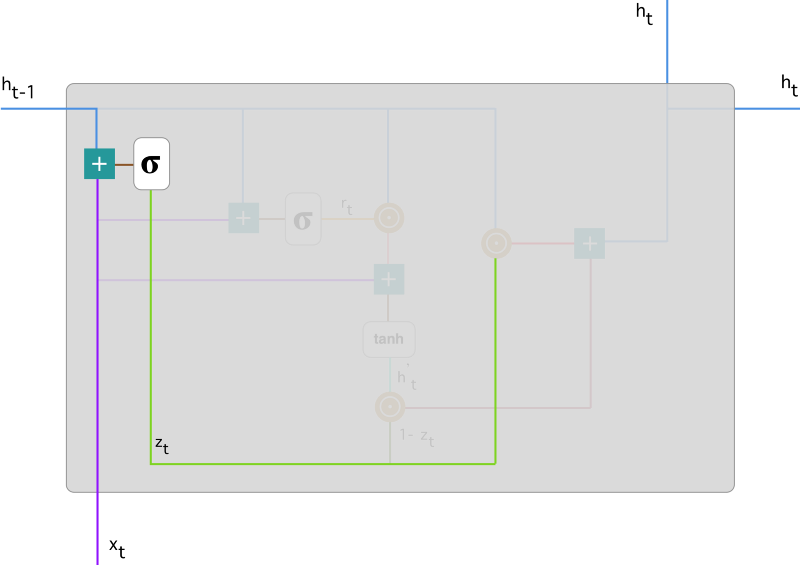

In [ ]:
with open('../static/GRU_update.png', 'rb') as file:
    img_update = Image.open(file)
    img_update.load()
img_update

$ z_t = \sigma \left( W^{(z)} x_t + U^{(z)} h_{t-1} \right) $

---
`The Reset Gate`

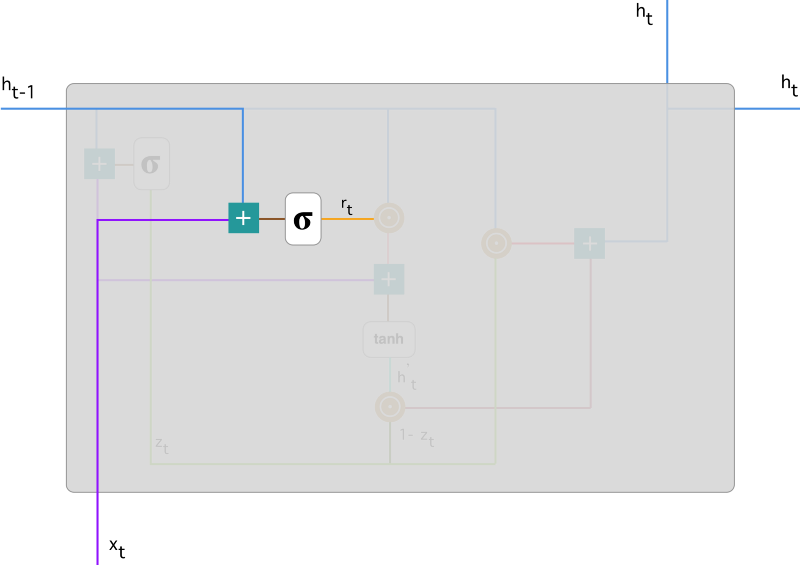

In [ ]:
with open('../static/GRU_reset.png', 'rb') as file:
    img_reset = Image.open(file)
    img_reset.load()
img_reset

$ r_t = \sigma \left( W^{(r)} x_t + U^{(r)} h_{t-1} \right) $


---
`Current Memory Content`

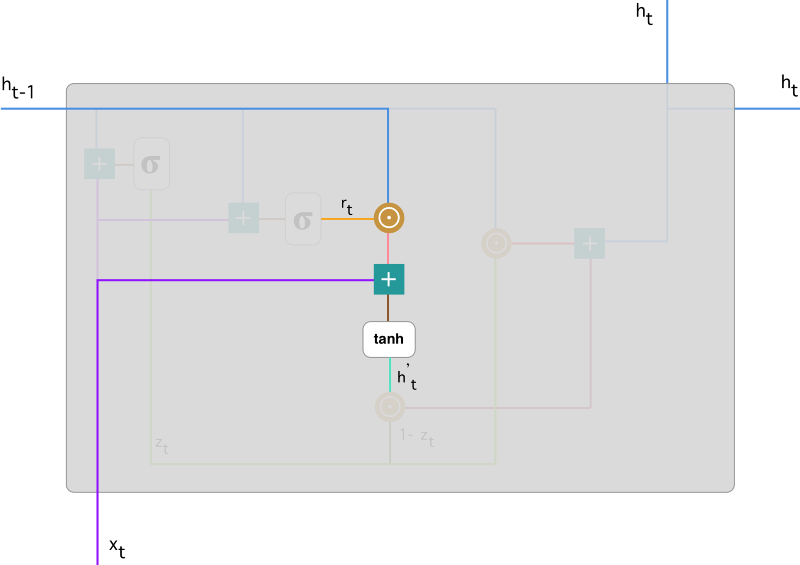

In [ ]:
with open('../static/GRU_curMem.png', 'rb') as file:
    img_cur_mem = Image.open(file)
    img_cur_mem.load()
img_cur_mem

$ h'_t = \tanh(W x_t + r_t \odot U h_{t-1}) $


---
`The Final Memory for The Current Time Step`

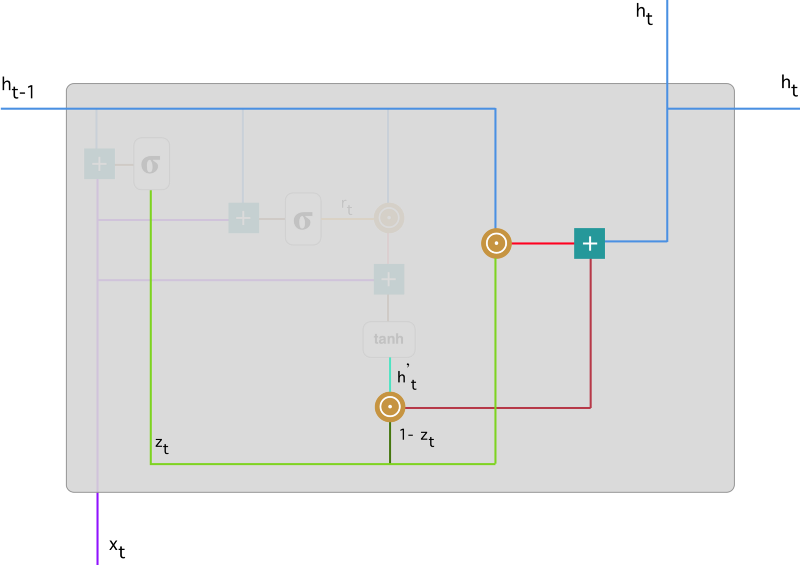

In [ ]:
with open('../static/GRU_finMem.png', 'rb') as file:
    img_fin_mem = Image.open(file)
    img_fin_mem.load()
img_fin_mem

$ h_t = z_t \odot h_{t-1} + (1 - z_t) \odot h'_t $


---
---

### Code

---
#### Data Reading

In the GRU model test, we used five input datasets respectively:

| Dataset | Data quantity(neg/pos/neu) | Accuracy |
|----------|----------|----------|
| [basic_data](../basic_data.csv) | 4846 (604/1363/2879) |  0.75 |
| [all_data_Wordnet_synonym](../all_data_Wordnet_synonym.csv) | 6813 (1208/2726/2879) | 0.79 |
| [all_data_Roberta_embedding](../all_data_Roberta_embedding.csv) | 6813 (1208/2726/2879) | 0.81 |
| [all_data_backtranslation](../all_data_backtranslation.csv) | 6813 (1208/2726/2879) | 0.81 |
| [all_data_new_basedonsynonym(final)](../all_data_new_basedonsynonym.csv) | 8021 (2416/2726/2879) | 0.83 |

The specific output data is located after the code.

Because the same model and hierarchical structure are used for different databases, only the code when using the [all_data_new_basedonsynonym(final)](../all_data_new_basedonsynonym.csv) data set is shown below, and the performance when using different data sets is attached at the end.


In [ ]:
import pandas as pd

# Read CSV file
file_path = '../all_data_new_basedonsynonym.csv'
'''
Parameters:
file_path: the path to the CSV file.
encoding='ISO-8859-1': used to handle special characters in the dataset.
header=None: used to specify that the dataset does not have a header.
names=['label', 'sentence']: used to specify the column names of the dataset.
'''
data = pd.read_csv(file_path, encoding='ISO-8859-1', header=None, names=['label', 'sentence'])

# View the number of rows and first few rows of data
print(data.shape)
print(data.head())

(8021, 2)
      label                                           sentence
0   neutral  According to Gran , the company has no plans t...
1   neutral  Technopolis plans to develop in stages an area...
2  negative  The international electronic industry company ...
3  positive  With the new production plant the company woul...
4  positive  According to the company 's updated strategy f...


---
#### Data Preprocessing

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Tag encoding
label_map = {'positive': 0, 'negative': 1, 'neutral': 2}
# Only keep the tags in the tag column
data = data[data['label'].isin(label_map.keys())]
data['label'] = data['label'].map(label_map)

# Random data splitting
X = data['sentence'].values
y = data['label'].values
'''
Parameters:
X: the feature data.
y: the target data.
test_size=0.2: the proportion of the test set.
random_state=42: the random seed.
stratify=y: used to ensure that the proportion of each class in the training set and test set is the same.
'''
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)
print(X_train[:2], y_train[:2])

# Text preprocessing
# Tokenization
tokenizer = Tokenizer(num_words=5000)
# Fit the tokenizer on the training data
tokenizer.fit_on_texts(X_train)
# Convert text to sequence
X_train_seq = tokenizer.texts_to_sequences(X_train)
# Convert text to sequence
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Statistical sequence length distribution (for determining the length of padding sequences)
seq_lengths = [len(seq) for seq in X_train_seq]
print(pd.Series(seq_lengths).describe())

# padding sequence
# Set the maximum sequence length
max_seq_len = 70
# Padding the sequence to the same length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_seq_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_seq_len)
print(X_train_pad[:2])

# Convert tags to one-hot encoding
y_train = to_categorical(y_train, num_classes=len(label_map))
y_test = to_categorical(y_test, num_classes=len(label_map))
print(y_train[:10])


['`` Capital expenditure on energy efficiency has unfortunately fallen along with the decline in the economy .'
 'Jussi Pesonen , member of the Sampo Board since 2006 , will renounce his seat in Sampo Board .'] [1 2]
count    6416.000000
mean       21.602400
std         9.525195
min         1.000000
25%        14.000000
50%        20.000000
75%        28.000000
max        66.000000
dtype: float64
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0  118
  3033   12  302  553   25 3034 3035 1762   22    1 1358    3    1 1635]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0  

---
#### Model Building

In [ ]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Embedding, \
        Bidirectional, \
        GRU, \
        Dense,\
        Dropout,\
        BatchNormalization, \
        GlobalAveragePooling1D, \
        AdditiveAttention,\
        Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Input Layer.
'''
Purpose:
Defines the input layer of the model.

Parameters:
max_seq_len represents the maximum length of the input sequences.
'''
inputs = Input(shape=(max_seq_len,))

# Embedding Layer
'''
Purpose:
Maps discrete word indices (integer tokens) into continuous dense vectors of fixed size.

Parameters:
input_dim=5000: the size of the vocabulary,
output_dim=128: the size of each embedding vector.
'''
embedding = Embedding(input_dim=5000, output_dim=128)(inputs)

# Bidirectional GRU Layer
'''
Purpose:
A Bidirectional GRU layer processes the input sequence in both forward and backward directions,
allowing the network to capture information from both past and future states.

Parameters:
units=128: Number of GRU units.
return_sequences=True: Returns the full sequence of outputs.
kernel_regularizer=l2(0.01): Applies L2 regularization to the weights to prevent overfitting.
recurrent_regularizer=l2(0.01): Applies L2 regularization to the recurrent weights.
dropout=0.2: Dropout rate of 20% on the inputs.
recurrent_dropout=0.2: Dropout rate of 20% on the recurrent state.
'''
bi_gru = Bidirectional(GRU(units=128,
                           return_sequences=True,
                           kernel_regularizer=l2(0.01),
                           recurrent_regularizer=l2(0.01),
                           dropout=0.2,
                           recurrent_dropout=0.2))(embedding)

# Additive Attention Layer
'''
Purpose:
The Additive Attention mechanism focuses on different parts of the input sequence,
allowing the model to pay more attention to certain aspects of the sequence when making predictions.
It combines the sequence outputs with themselves to enhance important features.
'''
attention = AdditiveAttention()([bi_gru, bi_gru])

# Global Average Pooling Layer
'''
Purpose:
Performs global average pooling on the output of the attention layer,
reducing the dimensionality by averaging over the time steps.
This creates a fixed-size output regardless of the input sequence length,
which is useful for subsequent fully connected layers.
'''
global_avg_pool = GlobalAveragePooling1D()(attention)

# Batch Normalization Layer
'''
Purpose:
Applies batch normalization to stabilize and
accelerate the training process by normalizing the output of the previous layer.
'''
batch_norm = BatchNormalization()(global_avg_pool)

# Dense Layer with L2 Regularization
'''
Purpose:
A fully connected layer that further processes the data.

Parameters:
units=128: The output dimension.
activation='relu': Uses the ReLU activation function for introducing non-linearity.
kernel_regularizer=l2(0.01): Applies L2 regularization to the layer's weights to prevent overfitting.
'''
dense = Dense(units=128, activation='relu', kernel_regularizer=l2(0.01))(batch_norm)

# Dropout Layer
'''
Purpose:
The final output layer, which produces the probabilities of each class in a multi-class classification problem.

Parameters:
units=len(label_map): Number of output classes.
activation='softmax': The softmax activation function outputs a probability distribution over the classes.
'''
dropout = Dropout(rate=0.5)(dense)
'''
Purpose:
A fully connected layer that further processes the data.

Parameters:
units=len(label_map): The number of output classes.
activation='softmax': The softmax activation function outputs a probability distribution over the classes.
'''
outputs = Dense(units=len(label_map), activation='softmax')(dropout)

# create model
'''
Purpose:
Creates a model with the defined input and output layers.

Parameters:
inputs: Input layer of the model.
outputs: Output layer of the model.
'''
model = Model(inputs=inputs, outputs=outputs)

# compile model
'''
Purpose:
Compiles the model with the Adam optimizer, categorical crossentropy loss, and accuracy metric.

Parameters:
optimizer=Adam(learning_rate=0.001): Adam optimizer with a learning rate of 0.001.
loss='categorical_crossentropy': Categorical crossentropy loss for multi-class classification.
metrics=['accuracy']: Evaluates the model performance based on accuracy.
'''
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# set Early Stopping
'''
Purpose:
Defines the early stopping callback to prevent overfitting.

Parameters:
monitor='val_loss': Monitors the validation loss.
patience=3: Number of epochs with no improvement after which training will be stopped.
restore_best_weights=True: Restores the best model weights based on the validation loss.
'''
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=3,
                               restore_best_weights=True)

# train model
'''
Purpose:
Trains the model on the training data.

Parameters:
X_train_pad: Padded input sequences for training.
y_train: One-hot encoded labels for training.
epochs=32: Number of training epochs.
batch_size=32: Number of samples per gradient update.
validation_split=0.2: Fraction of training data to use for validation.
verbose=1: Prints progress bar during training.
callbacks=[early_stopping]: Early stopping callback to prevent overfitting.
'''
history = model.fit(X_train_pad, y_train,
                    epochs=32,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[early_stopping])


Epoch 1/32
161/161 ━━━━━━━━━━━━━━━━━━━━ 26s 144ms/step - accuracy: 0.4649 - loss: 5.7234 - val_accuracy: 0.5265 - val_loss: 1.9439
Epoch 2/32
161/161 ━━━━━━━━━━━━━━━━━━━━ 23s 141ms/step - accuracy: 0.8234 - loss: 1.1512 - val_accuracy: 0.7079 - val_loss: 1.0818
Epoch 3/32
161/161 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 0.9224 - loss: 0.4532 - val_accuracy: 0.7975 - val_loss: 0.7155
Epoch 4/32
161/161 ━━━━━━━━━━━━━━━━━━━━ 25s 157ms/step - accuracy: 0.9469 - loss: 0.2841 - val_accuracy: 0.8536 - val_loss: 0.5109
Epoch 5/32
161/161 ━━━━━━━━━━━━━━━━━━━━ 25s 156ms/step - accuracy: 0.9634 - loss: 0.2041 - val_accuracy: 0.8458 - val_loss: 0.5141
Epoch 6/32
161/161 ━━━━━━━━━━━━━━━━━━━━ 33s 204ms/step - accuracy: 0.9685 - loss: 0.1777 - val_accuracy: 0.8388 - val_loss: 0.5542
Epoch 7/32
161/161 ━━━━━━━━━━━━━━━━━━━━ 41s 251ms/step - accuracy: 0.9742 - loss: 0.1568 - val_accuracy: 0.8474 - val_loss: 0.6180


---
#### Show Model Loss

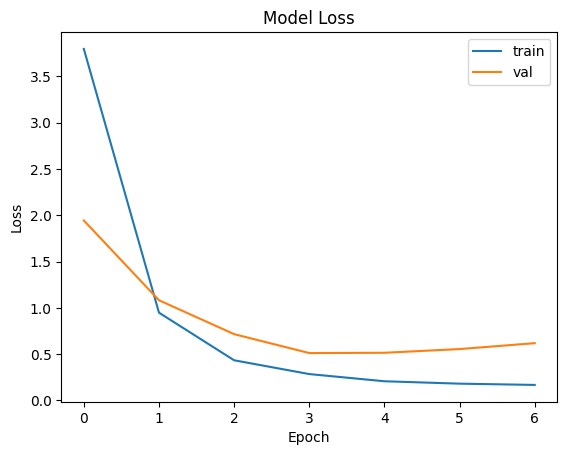

In [ ]:
import matplotlib.pyplot as plt
# Plot accuracy
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
# Set the title, x-axis label, y-axis label, and legend
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

---
#### Evaluation Model

51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8208 - loss: 0.5764
Test Loss: 0.56
Test Accuracy: 0.83
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step
              precision    recall  f1-score   support

    positive       0.79      0.80      0.79       546
    negative       0.86      0.97      0.91       483
     neutral       0.84      0.74      0.79       576

    accuracy                           0.83      1605
   macro avg       0.83      0.84      0.83      1605
weighted avg       0.83      0.83      0.83      1605



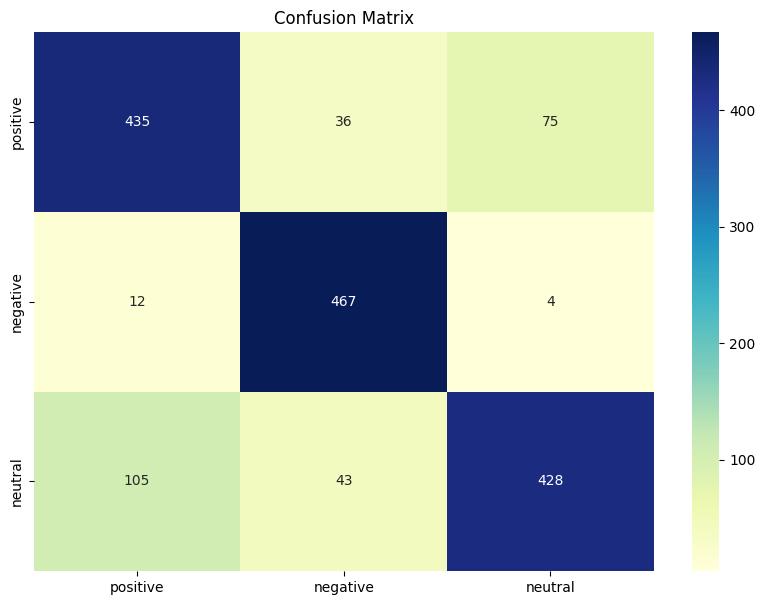

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Test Loss: {loss:.2f}')
print(f'Test Accuracy: {accuracy:.2f}')

# Predictions
y_pred_prob = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Output evaluation metrics
print(classification_report(y_test_labels, y_pred,
                            target_names=label_map.keys(),
                            zero_division=0
                            ))

# Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=label_map.keys(), index=label_map.keys())
plt.figure(figsize=(10, 7))
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix')
plt.show()


---
---
### (Appendix)Specific outputs using other datasets

---
#### GRU outputs(use basic_data.csv)

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.7359 - loss: 0.8382
Test Loss: 0.82
Test Accuracy: 0.75
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
              precision    recall  f1-score   support

    positive       0.73      0.51      0.60       273
    negative       0.71      0.58      0.64       121
     neutral       0.76      0.89      0.82       576

    accuracy                           0.75       970
   macro avg       0.73      0.66      0.68       970
weighted avg       0.74      0.75      0.73       970



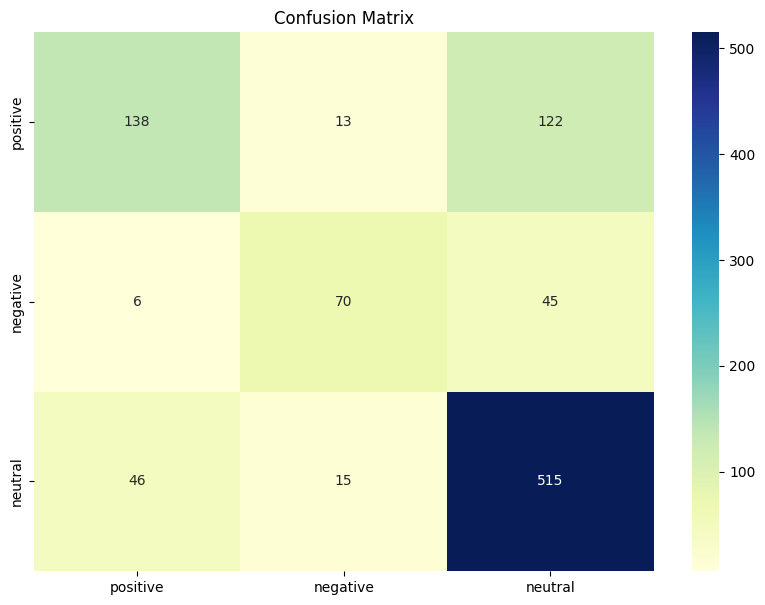

In [ ]:
file_path = '../basic_data.csv'
'''
Omit code...
'''
plt.show()

---
#### GRU outputs(use all_data_Wordnet_synonym.csv)

43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8072 - loss: 0.6035
Test Loss: 0.65
Test Accuracy: 0.79
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step
              precision    recall  f1-score   support

    positive       0.75      0.84      0.79       545
    negative       0.93      0.62      0.74       242
     neutral       0.78      0.81      0.79       576

    accuracy                           0.79      1363
   macro avg       0.82      0.75      0.78      1363
weighted avg       0.80      0.79      0.78      1363



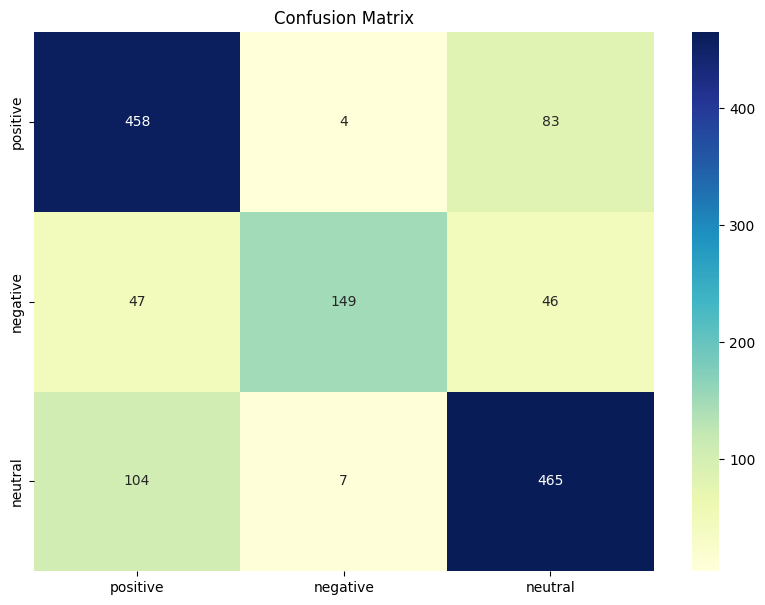

In [ ]:
file_path = '../all_data_Wordnet_synonym.csv'
'''
Omit code...
'''
plt.show()

---
#### GRU outputs(use all_data_Roberta_embedding.csv)

43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.8170 - loss: 0.6053
Test Loss: 0.63
Test Accuracy: 0.81
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step
              precision    recall  f1-score   support

    positive       0.82      0.80      0.81       545
    negative       0.87      0.70      0.78       242
     neutral       0.77      0.86      0.81       576

    accuracy                           0.81      1363
   macro avg       0.82      0.78      0.80      1363
weighted avg       0.81      0.81      0.80      1363



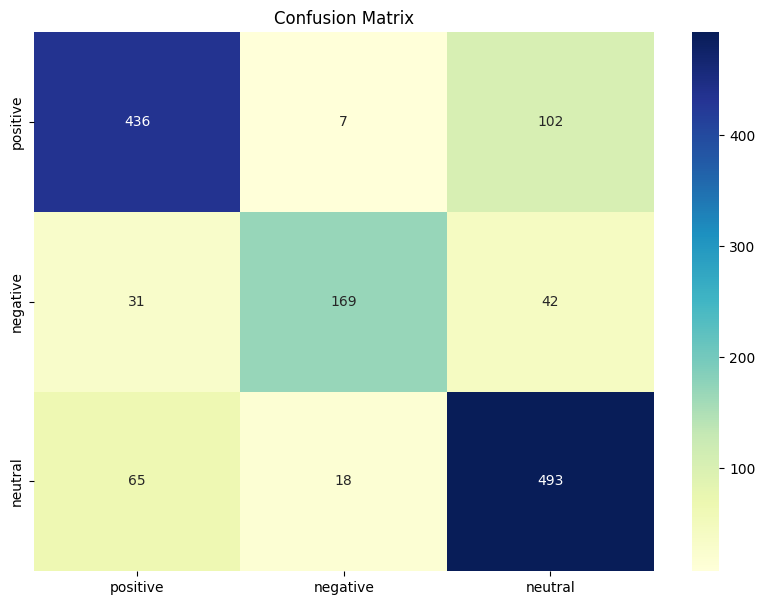

In [ ]:
file_path = '../all_data_Roberta_embedding.csv'
'''
Omit code...
'''
plt.show()

---
#### GRU outputs(use all_data_backtranslation.csv)

43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.8345 - loss: 0.5998
Test Loss: 0.67
Test Accuracy: 0.81
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
              precision    recall  f1-score   support

    positive       0.80      0.82      0.81       545
    negative       0.84      0.78      0.81       242
     neutral       0.80      0.81      0.80       576

    accuracy                           0.81      1363
   macro avg       0.81      0.80      0.81      1363
weighted avg       0.81      0.81      0.81      1363



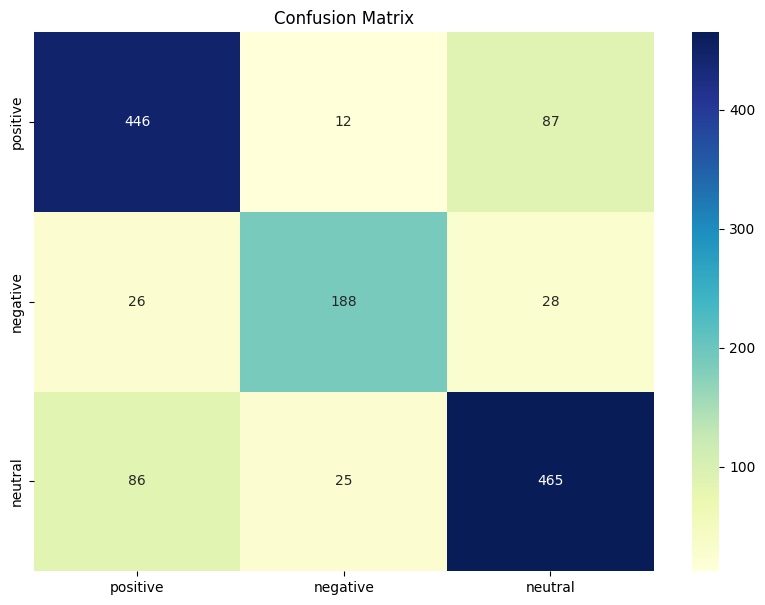

In [ ]:
file_path = '../all_data_Roberta_embedding.csv'
'''
Omit code...
'''
plt.show()

##BERT##

### Introduction of BERT

BERT (Bidirectional Encoder Representations from Transformers) is a pre-trained language representation model proposed by the Google AI Language team. Its main feature is bidirectionality, which means that it takes into account not only the left context of the word but also the right context when training. BERT's architecture is based on Transformer. Specifically, it uses a multi-layer bidirectional Transformer encoder.

### Comparative Analysis of BERT with GRU and LSTM

1. Bidirectionality
The bidirectionality of BERT allows the model to consider both the context before and after each word in a sentence. This means that when processing a word, BERT understands both its left and right contexts, thus capturing more semantic information. In contrast, traditional RNNs, GRUs and LSTMs are usually unidirectional (although bidirectional versions are also available) and can only rely on forward or backward contextual information.

2. Bidirectionality
BERT, based on the Transformer architecture, utilises a self-attention mechanism. The self-attention mechanism allows the model to automatically focus on other related words in the sentence when processing a certain word, thus better capturing long-distance dependencies. In contrast, although GRU and LSTM can capture long-distance dependencies in sequences, their recursive structure limits the parallel computation ability, and the effect may be reduced when processing very long sequences.

3. Parallel Computing Efficiency
BERT's Transformer architecture supports highly parallelised computation as it does not rely on recursive processing of sequences. In contrast, GRU and LSTM are difficult to parallelise computation due to their recursive nature, resulting in lower computational efficiency when dealing with large-scale data.

4. Pre-training and fine-tuning
BERT's pre-training approach (e.g., masked language modelling and next sentence prediction) enables it to learn rich language representations. During the fine-tuning phase, BERT can be quickly adapted to the needs of a specific task. Although GRU and LSTM can be trained in a similar way, BERT's pre-training and fine-tuning architecture is designed to be more systematic and efficient.

### implementation process

**Stage One**: Pre-training with General Language Data
Objective: The pre-training phase involves training BERT on a large corpus of general language data to capture a broad understanding of linguistic patterns and context. This is done using two key tasks:

Masked Language Modeling (MLM): Random tokens in the input are masked, and the model is trained to predict these masked tokens. This helps BERT understand the context surrounding each word.

Next Sentence Prediction (NSP): The model is trained to predict whether a given sentence follows another, helping it grasp the relationships between sentences.
Through these tasks, BERT learns to generate deep bidirectional representations of language, capturing context from both directions in the sentence.

**Stage Two**: Fine-Tuning on Financial Sentiment Data
Objective: The fine-tuning stage focuses on adapting BERT's pre-trained model to the specific task of financial sentiment classification. This involves training the model on a dataset labeled with financial sentiment categories such as positive, negative, and neutral.
Data Preparation: The dataset comprises financial news headlines and other relevant texts, labeled with sentiment scores. This data is crucial for teaching the model to understand domain-specific language and expressions used in financial contexts.

 Data Preprocessing

In [ ]:
def preprocess_data(data):
    data['Sentiment'] = data['Sentiment'].replace(['positive', 'neutral', 'negative'], [2, 1, 0])
    return data

data = preprocess_data(data)

Split the data into training and testing sets

In [ ]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

Load BERT Tokenizer and Model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

Dataset class

In [ ]:
class FinancialDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

Tokenize data

In [ ]:
def tokenize_data(data):
    return tokenizer(data['Text'].tolist(), truncation=True, padding=True, max_length=512)

train_encodings = tokenize_data(train_data)
test_encodings = tokenize_data(test_data)

train_dataset = FinancialDataset(train_encodings, train_data['Sentiment'].tolist())
test_dataset = FinancialDataset(test_encodings, test_data['Sentiment'].tolist())

# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


Data collator

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### Finetune

Fine-Tuning Process:

**Task-Specific Adjustment**: During fine-tuning, BERT is further trained on the financial sentiment dataset. The pre-trained language model is adjusted to align with the task-specific objectives, such as identifying positive or negative sentiments in financial news.

**Domain-Specific Learning**: Fine-tuning allows the model to specialize in recognizing and interpreting financial terminology and jargon. It helps the model accurately discern sentiment nuances that are critical in financial texts, such as market forecasts, stock movements, and economic indicators.

Modify training parameters

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
)

Trainer

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=lambda p: {'accuracy': accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1))}
)

Result in basic_data.csv

C:\Users\zhangy\AppData\Local\Temp\ipykernel_15480\1625266277.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['label'] = data['label'].replace(['positive', 'neutral', 'negative'], [2, 1, 0])
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
d:\1-9444\023\finbert_baseline\.venv\lib\site-packages\transformers\training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/2046 [00:00<?, ?it/s]

{'loss': 0.5479, 'grad_norm': 30.658061981201172, 'learning_rate': 1.5112414467253179e-05, 'epoch': 0.73}


  0%|          | 0/171 [00:00<?, ?it/s]

{'eval_loss': 0.3961244225502014, 'eval_accuracy': 0.8591342626559061, 'eval_runtime': 64.5605, 'eval_samples_per_second': 21.112, 'eval_steps_per_second': 2.649, 'epoch': 1.0}
{'loss': 0.3185, 'grad_norm': 0.15241731703281403, 'learning_rate': 1.0224828934506354e-05, 'epoch': 1.47}


  0%|          | 0/171 [00:00<?, ?it/s]

{'eval_loss': 0.6134241223335266, 'eval_accuracy': 0.8517975055025678, 'eval_runtime': 65.3436, 'eval_samples_per_second': 20.859, 'eval_steps_per_second': 2.617, 'epoch': 2.0}
{'loss': 0.1871, 'grad_norm': 5.076646327972412, 'learning_rate': 5.337243401759531e-06, 'epoch': 2.2}
{'loss': 0.0937, 'grad_norm': 0.047580037266016006, 'learning_rate': 4.496578690127078e-07, 'epoch': 2.93}


  0%|          | 0/171 [00:00<?, ?it/s]

{'eval_loss': 0.590268075466156, 'eval_accuracy': 0.8811445341159208, 'eval_runtime': 62.9532, 'eval_samples_per_second': 21.651, 'eval_steps_per_second': 2.716, 'epoch': 3.0}
{'train_runtime': 5488.0248, 'train_samples_per_second': 2.979, 'train_steps_per_second': 0.373, 'train_loss': 0.2823980348667208, 'epoch': 3.0}


  0%|          | 0/171 [00:00<?, ?it/s]

Accuracy-Score: 0.8811445341159208


  0%|          | 0/171 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       216
           1       0.94      0.82      0.88       576
           2       0.83      0.95      0.89       571

    accuracy                           0.88      1363
   macro avg       0.89      0.88      0.88      1363
weighted avg       0.89      0.88      0.88      1363



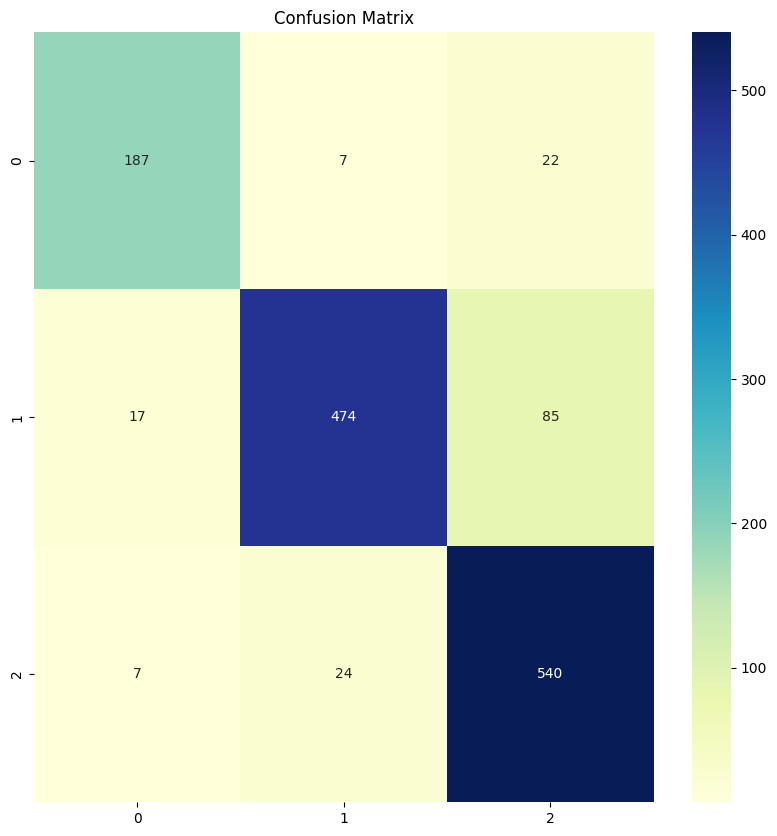

In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
import seaborn as sns
import matplotlib.pyplot as plt

# 数据预处理
def preprocess_data(data):
    data['label'] = data['label'].replace(['positive', 'neutral', 'negative'], [2, 1, 0])
    return data

data = preprocess_data(data)

# 将数据分成训练集和测试集
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# 加载BERT的Tokenizer和模型
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

# 数据集类
class FinancialDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Tokenize数据
def tokenize_data(data):
    return tokenizer(data['text'].tolist(), truncation=True, padding=True, max_length=512)

train_encodings = tokenize_data(train_data)
test_encodings = tokenize_data(test_data)

train_dataset = FinancialDataset(train_encodings, train_data['label'].tolist())
test_dataset = FinancialDataset(test_encodings, test_data['label'].tolist())

# 数据填充器
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 训练参数
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=lambda p: {'accuracy': accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1))}
)

# 训练模型
trainer.train()

# 评估模型
results = trainer.evaluate()
print(f"Accuracy-Score: {results['eval_accuracy']}")

# 预测并评估
predictions = trainer.predict(test_dataset)
y_preds = np.argmax(predictions.predictions, axis=1)
y_true = test_data['label'].tolist()

print(classification_report(y_true, y_preds))
cm = confusion_matrix(y_true, y_preds)
cm_matrix = pd.DataFrame(data=cm)
plt.figure(figsize=(10,10))
sns.heatmap(cm_matrix, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Confusion Matrix')
plt.show()


C:\Users\zhangy\AppData\Local\Temp\ipykernel_27720\3999092829.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Sentiment'] = data['Sentiment'].replace(['positive', 'neutral', 'negative'], [2, 1, 0])
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
d:\1-9444\023\finbert_baseline\.venv\lib\site-packages\transformers\training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/1455 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

{'eval_loss': 0.3519984483718872, 'eval_accuracy': 0.8608247422680413, 'eval_runtime': 58.8776, 'eval_samples_per_second': 16.475, 'eval_steps_per_second': 2.072, 'epoch': 1.0}
{'loss': 0.5338, 'grad_norm': 18.129247665405273, 'learning_rate': 1.3127147766323025e-05, 'epoch': 1.03}


  0%|          | 0/122 [00:00<?, ?it/s]

{'eval_loss': 0.47318217158317566, 'eval_accuracy': 0.8587628865979381, 'eval_runtime': 62.5532, 'eval_samples_per_second': 15.507, 'eval_steps_per_second': 1.95, 'epoch': 2.0}
{'loss': 0.2513, 'grad_norm': 0.12033254653215408, 'learning_rate': 6.254295532646049e-06, 'epoch': 2.06}


  0%|          | 0/122 [00:00<?, ?it/s]

{'eval_loss': 0.5698260068893433, 'eval_accuracy': 0.865979381443299, 'eval_runtime': 65.8462, 'eval_samples_per_second': 14.731, 'eval_steps_per_second': 1.853, 'epoch': 3.0}
{'train_runtime': 3883.9802, 'train_samples_per_second': 2.994, 'train_steps_per_second': 0.375, 'train_loss': 0.31339659805560033, 'epoch': 3.0}


  0%|          | 0/122 [00:00<?, ?it/s]

Accuracy-Score: 0.865979381443299


  0%|          | 0/122 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.86      0.83      0.84       110
           1       0.88      0.92      0.90       571
           2       0.83      0.78      0.81       289

    accuracy                           0.87       970
   macro avg       0.86      0.84      0.85       970
weighted avg       0.86      0.87      0.86       970



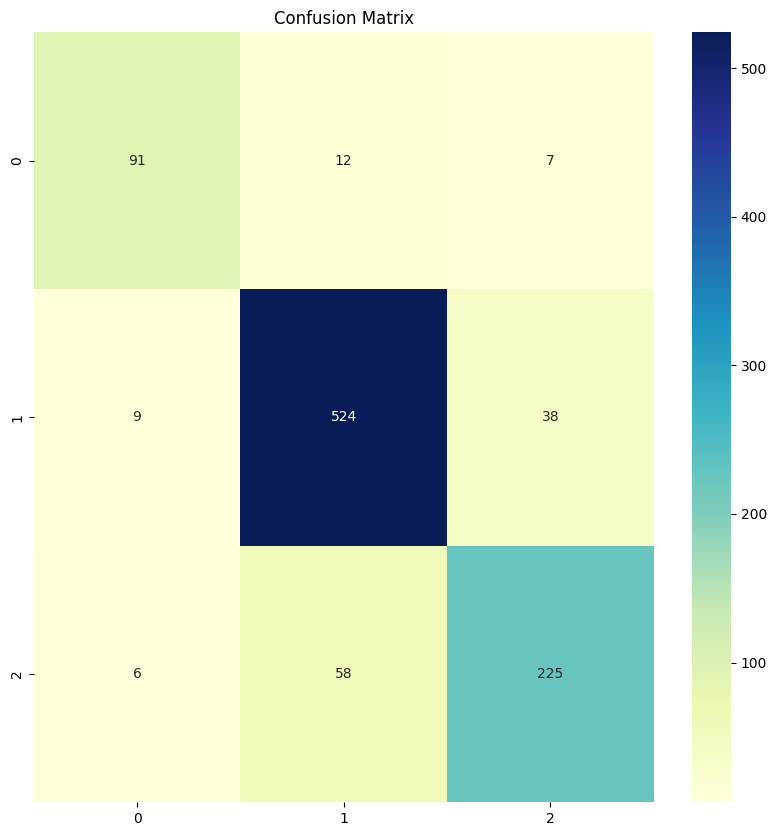

In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
import seaborn as sns
import matplotlib.pyplot as plt

# 数据预处理
def preprocess_data(data):
    data['Sentiment'] = data['Sentiment'].replace(['positive', 'neutral', 'negative'], [2, 1, 0])
    return data

data = preprocess_data(data)

# 将数据分成训练集和测试集
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# 加载BERT的Tokenizer和模型
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

# 数据集类
class FinancialDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Tokenize数据
def tokenize_data(data):
    return tokenizer(data['Text'].tolist(), truncation=True, padding=True, max_length=512)

train_encodings = tokenize_data(train_data)
test_encodings = tokenize_data(test_data)

train_dataset = FinancialDataset(train_encodings, train_data['Sentiment'].tolist())
test_dataset = FinancialDataset(test_encodings, test_data['Sentiment'].tolist())

# 数据填充器
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 训练参数
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=lambda p: {'accuracy': accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1))}
)

# 训练模型
trainer.train()

# 评估模型
results = trainer.evaluate()
print(f"Accuracy-Score: {results['eval_accuracy']}")

# 预测并评估
predictions = trainer.predict(test_dataset)
y_preds = np.argmax(predictions.predictions, axis=1)
y_true = test_data['Sentiment'].tolist()

print(classification_report(y_true, y_preds))
cm = confusion_matrix(y_true, y_preds)
cm_matrix = pd.DataFrame(data=cm)
plt.figure(figsize=(10,10))
sns.heatmap(cm_matrix, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Confusion Matrix')
plt.show()


Result in finnal dataset

C:\Users\zhangy\AppData\Local\Temp\ipykernel_12864\3999092829.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Sentiment'] = data['Sentiment'].replace(['positive', 'neutral', 'negative'], [2, 1, 0])
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
d:\1-9444\023\finbert_baseline\.venv\lib\site-packages\transformers\training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/2406 [00:00<?, ?it/s]

{'loss': 0.5634, 'grad_norm': 38.42001724243164, 'learning_rate': 1.5843724023275145e-05, 'epoch': 0.62}


  0%|          | 0/201 [00:00<?, ?it/s]

{'eval_loss': 0.35491257905960083, 'eval_accuracy': 0.8679127725856698, 'eval_runtime': 124.8949, 'eval_samples_per_second': 12.851, 'eval_steps_per_second': 1.609, 'epoch': 1.0}
{'loss': 0.2995, 'grad_norm': 66.28247833251953, 'learning_rate': 1.1687448046550292e-05, 'epoch': 1.25}
{'loss': 0.2134, 'grad_norm': 5.103343486785889, 'learning_rate': 7.531172069825436e-06, 'epoch': 1.87}


  0%|          | 0/201 [00:00<?, ?it/s]

{'eval_loss': 0.3768737316131592, 'eval_accuracy': 0.9077881619937694, 'eval_runtime': 80.0413, 'eval_samples_per_second': 20.052, 'eval_steps_per_second': 2.511, 'epoch': 2.0}
{'loss': 0.0932, 'grad_norm': 0.03577035665512085, 'learning_rate': 3.374896093100582e-06, 'epoch': 2.49}


  0%|          | 0/201 [00:00<?, ?it/s]

{'eval_loss': 0.4430125951766968, 'eval_accuracy': 0.9096573208722741, 'eval_runtime': 80.5322, 'eval_samples_per_second': 19.93, 'eval_steps_per_second': 2.496, 'epoch': 3.0}
{'train_runtime': 6731.6866, 'train_samples_per_second': 2.859, 'train_steps_per_second': 0.357, 'train_loss': 0.2568873613948933, 'epoch': 3.0}


  0%|          | 0/201 [00:00<?, ?it/s]

Accuracy-Score: 0.9096573208722741


  0%|          | 0/201 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       469
           1       0.87      0.91      0.89       575
           2       0.90      0.86      0.88       561

    accuracy                           0.91      1605
   macro avg       0.91      0.91      0.91      1605
weighted avg       0.91      0.91      0.91      1605



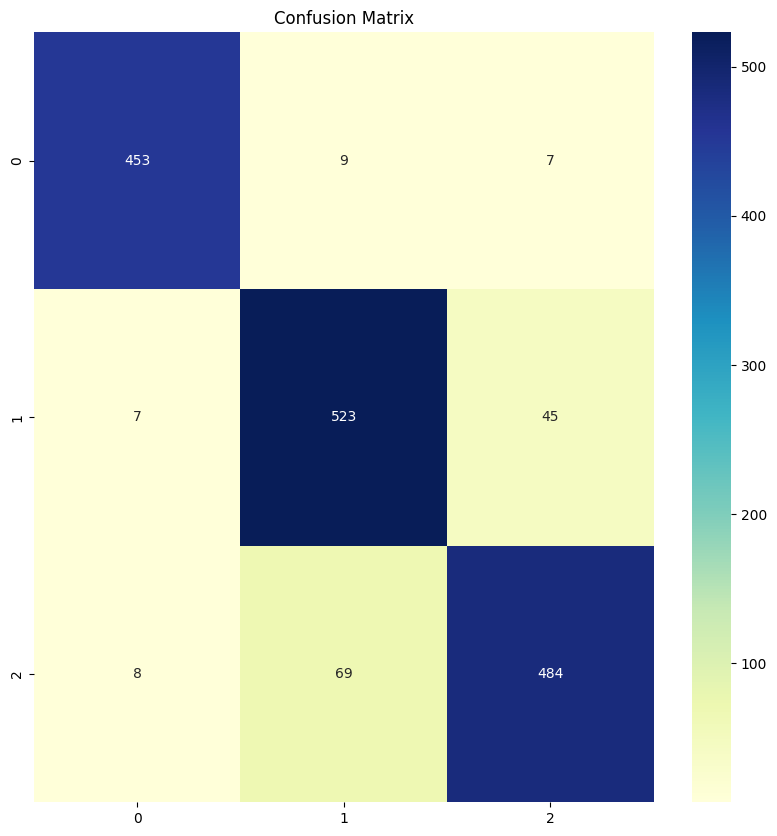

In [ ]:
# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()
print(f"Accuracy-Score: {results['eval_accuracy']}")

# Predict and evaluate
predictions = trainer.predict(test_dataset)
y_preds = np.argmax(predictions.predictions, axis=1)
y_true = test_data['Sentiment'].tolist()

print(classification_report(y_true, y_preds))
cm = confusion_matrix(y_true, y_preds)
cm_matrix = pd.DataFrame(data=cm)
plt.figure(figsize=(10,10))
sns.heatmap(cm_matrix, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Confusion Matrix')
plt.show()


## Finbert

# 4. Results


# 5. Discussion and Comparative Result

<table style="width: 100%; border-collapse: collapse; margin: 0; padding: 0;">
  <thead>
    <tr>
      <th style="border: 1px solid black; padding: 8px; text-align: left; background-color: #f2f2f2;"></th>
      <th style="border: 1px solid black; padding: 8px; text-align: left; background-color: #f2f2f2;">LSTM</th>
      <th style="border: 1px solid black; padding: 8px; text-align: left; background-color: #f2f2f2;">GRU</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="border: 1px solid black; padding: 8px; text-align: left;">result(Accuracy)</td>
      <td style="border: 1px solid black; padding: 8px; text-align: left;">84%</td>
      <td style="border: 1px solid black; padding: 8px; text-align: left;">83%</td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 8px; text-align: left;">result analysis</td>
      <td colspan="2" style="border: 1px solid black; padding: 8px; text-align: left;">LSTM and GRU perform similarly, Bert and Finbert perform better, with Finbert performing the best</td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 8px; text-align: left;">strengths</td>
      <td style="border: 1px solid black; padding: 8px; text-align: left;"><div>Long-term memory: Capable of capturing long-term dependencies and effectively processing long sequences of data.</div>
      <div>
      Anti-vanishing gradient: By introducing memory units and gating mechanisms, the problem of gradient disappearance is effectively alleviated.</div></td>
      <td style="border: 1px solid black; padding: 8px; text-align: left;">Simple structure: simpler than LSTM and more computationally efficient.<br>Comparable performance: Performance is comparable to or better than LSTM on many tasks.</td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 8px; text-align: left;">weaknesses</td>
      <td style="border: 1px solid black; padding: 8px; text-align: left;">High computational complexity: Due to the complex structure, the calculation and training time is long.<br>Difficult to parallelize: Parallel processing is difficult and inefficient on modern hardware.</td>
      <td style="border: 1px solid black; padding: 8px; text-align: left;">Limited expressive power: Due to the lack of output gates, the expressive power may not be as good as LSTM.</td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 8px; text-align: left;">limitations</td>
      <td style="border: 1px solid black; padding: 8px; text-align: left;">Long sequence processing: Although better than RNN, it still has certain limitations when processing very long sequences.<br>Model tuning is complex: hyperparameters need to be carefully adjusted, and the training process is complicated.</td>
      <td style="border: 1px solid black; padding: 8px; text-align: left;">Long sequence processing: Similar to LSTM, there are still limitations when processing very long sequences.<br>Difficulty in model selection: In some tasks, choosing GRU or LSTM requires experimental comparison.</td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 8px; text-align: left;">future_work</td>
      <td style="border: 1px solid black; padding: 8px; text-align: left;">Optimize structure: Simplify the structure to improve calculation efficiency.<br>Hybrid models: Combine with other models, such as Transformers, to enhance performance.<br>Hardware acceleration: Utilize dedicated hardware such as TPU for acceleration.</td>
      <td style="border: 1px solid black; padding: 8px; text-align: left;">Structural improvement: further simplify and optimize the GRU structure.<br>Application expansion: Explore the application of GRU in more tasks.</td>
    </tr>
  </tbody>
</table>



<table>
    <tr>
        <th></th>
        <th>Bert</th>
        <th>Finbert</th>
    </tr>
    <tr>
        <td>result (Accuracy)</td>
        <td>91%</td>
        <td>92%</td>
    </tr>
    <tr>
        <td>result analysis</td>
        <td colspan="2">LSTM and GRU perform similarly, Bert and Finbert perform better, with Finbert performing the best</td>
    </tr>
    <tr>
        <td>strengths</td>
        <td>
            Bidirectional context: Using bidirectional Transformer, you can capture richer contextual information.<br>
            Pre-training and fine-tuning: Excellent performance on a variety of NLP tasks through large-scale pre-training and task-specific fine-tuning.
        </td>
        <td>
            Domain adaptability: Excellent performance in financial text processing, suitable for specific tasks in the financial field.<br>
            Advantages of pre-training: The pre-training model based on BERT has strong language understanding capabilities.
        </td>
    </tr>
    <tr>
        <td>weaknesses</td>
        <td>
            High computing resource requirements: A large amount of computing resources are required for pre-training.<br>
            Long inference time: The model is huge and the inference time is long.
        </td>
        <td>
            High data requirements: A large amount of financial field data is required for pre-training.<br>
            Limited applicability: It is mainly suitable for the financial field and has poor adaptability to other fields.
        </td>
    </tr>
    <tr>
        <td>limitations</td>
        <td>
            Reliance on large-scale data: Performance relies on large-scale pre-training data.<br>
            Adaptability: Adaptability to a specific task or domain still requires fine-tuning.
        </td>
        <td>
            Field limitations: It can only process texts in the financial field, and its versatility is not as good as BERT.<br>
            Update frequency: The financial field changes rapidly, and models need to be updated frequently to maintain accuracy.
        </td>
    </tr>
    <tr>
        <td>future work</td>
        <td>
            Model compression: Reduce the size of the model through techniques such as knowledge distillation and quantification.<br>
            Multi-task learning: Explore more efficient multi-task learning methods.<br>
            Field adaptation: Enhance adaptability in specific fields (such as medicine, law).
        </td>
        <td>
            Continuous updates: Regularly update the model to adapt to changes in financial markets.<br>
            Cross-domain applications: Explore application possibilities in other fields (e.g., law, medicine).<br>
            Reinforcement learning: Incorporate reinforcement learning to improve model performance in dynamic environments.
        </td>
    </tr>
</table>



### FinBERT-baseline

#### Path to the dataset

####  Load a tagger from a pre-trained FinBERT model and convert the text data of the training, validation, and test sets into a tokenized sequence of fixed length for subsequent model training and evaluation

PyTorch dataset class for handling tokenized data

The transformers library imported the sequence classification model and tagger, AdamW optimizer

FinBERT classifier class for loading pre-trained models and markers, for model training, validation, and by drawing loss curves and confusion matrices

Dropout regularization LSTM sentiment analysis model

Losses, accuracy, and F1 scores of the model are calculated and recorded in the training and validation cycles

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
import numpy as np

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], '.2f' if normalize else 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Training and validation loop with individual plot outputs for performance metrics
train_losses, val_losses, val_accuracies, val_f1_scores = [], [], [], []
best_loss = float('inf')

for epoch in range(20):
    total_train_loss, total_val_loss, total_val_accuracy, total_count = 0, 0, 0, 0
    preds_list, labels_list = [], []

    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = check_indices(batch['input_ids'], vocab_size)
        labels = batch['labels']
        outputs = model(input_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    train_losses.append(total_train_loss / len(train_loader))

    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids']
            labels = batch['labels']
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            preds = outputs.argmax(1)
            correct = (preds == labels).type(torch.float).sum().item()
            total_val_accuracy += correct
            total_count += labels.size(0)
            preds_list.extend(preds.cpu().numpy())
            labels_list.extend(labels.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = total_val_accuracy / total_count
    val_f1 = f1_score(labels_list, preds_list, average='weighted')
    val_f1_scores.append(val_f1)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1: {val_f1:.4f}')

    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model_lstm.pth')
        print("Saved Best Model")

torch.save(model.state_dict(), 'final_model_lstm.pth')
print("Saved Final Model")

# Plot training and validation loss
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

# Plot validation accuracy
plt.figure(figsize=(10, 4))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

# Plot validation F1 score
plt.figure(figsize=(10, 4))
plt.plot(val_f1_scores, label='Validation F1 Score')
plt.title('Validation F1 Score')
plt.legend()
plt.show()

# Generate and plot the confusion matrix
cm = confusion_matrix(labels_list, preds_list)
plot_confusion_matrix(cm, classes=['Negative', 'Neutral', 'Positive'])

Reading CSV file

In [ ]:
# data = pd.read_csv('/kaggle/input/sentiment-analysis-for-financial-news/all-data.csv',
#                    encoding='unicode_escape',
#                    names=['Sentiment', 'Text'])
# data.head()
data = pd.read_csv('all-data.csv',
                   encoding='unicode_escape',
                   names=['Sentiment', 'Text'])
data.head(),len(data)

The text and emotion columns are converted to lists, respectively

In [ ]:
X = data['Text'].to_list()
y = data['Sentiment'].to_list()


print(f'x[0] like: {X[0]}...,\ny[0] like: {y[0]}...')

In the next step I will directly download [FineBERT](https://huggingface.co/ProsusAI/finbert) directly from Huggingface.

`AutoTokenizer` automatically selects the correct tokenizer for a given model.

`AutoModelForSequenceClassification` is a tool for loading pre-trained models.

After downloading, the model and tokenizer are stored in the local cache directory, usually at the following location:

`Linux/macOS: ~/.cache/huggingface/transformers`

`Windows: C:\Users\<YourUsername>\.cache\huggingface\transformers`

Load the marker and sequence classification model from the pre-trained model "ProsusAI/finbert"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

# 6. PREDICT - unknown
Finally we are able to loop over the X list and predict for every entry the label. I will safe the predicted label as well as the probability for that class.

Each text is tokenized and encoded, the emotion category and its probability are predicted by the model, and the predicted result and corresponding probability are recorded

In [ ]:
preds = []
preds_proba = []
tokenizer_kwargs = {"padding": True, "truncation": True, "max_length": 512}
for x in X:
    with torch.no_grad():
        # Word segmentation and encoding
        input_sequence = tokenizer(x, return_tensors="pt", **tokenizer_kwargs)

        # Model prediction
        logits = model(**input_sequence).logits

        # Calculate probability distribution
        scores = {
        k: v
        for k, v in zip(
            model.config.id2label.values(),
            scipy.special.softmax(logits.numpy().squeeze()),
        )
    }
    # Find the emotion category with the highest probability and its probability
    sentimentFinbert = max(scores, key=scores.get)
    probabilityFinbert = max(scores.values())

    # Record the results
    preds.append(sentimentFinbert)
    preds_proba.append(probabilityFinbert)

type(logits), logits.shape

print(f"Preds: {preds[0]}")
print(f"Preds_proba: {preds_proba[0]}")


# 7. EVALUATION - unknown
Let´s check the performance of our model quick.
evaluation matrix lenght data for each class p

Prints out the accuracy rate between the predicted emotion category and the true emotion label

In [ ]:
print(f'Accuracy-Score: {accuracy_score(y, preds)}')

Print a categorical report of the predicted results and the true emotion label

In [ ]:
print(classification_report(y, preds))

Precision = $\frac{True \; pos}{True \; pos + False \; pos}$  (Take positive as an example)

Recall = $\frac{True \; pos}{True \; pos + False \; neg + False \; neu}$  (Take positive as an example)

F1-score = 2*$\frac{Precision*Recall}{Precision*Recall}$

Support : True sample number

A heat map of the confusion matrix between the predicted results and the true emotional labels is calculated and plotted

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(y, preds)
cm_matrix = pd.DataFrame(data=cm)

# Draw heat map
plt.figure(figsize=(10,10))
sns.heatmap(cm_matrix, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Confusion Matrix')
plt.show()

The output is really good. Around 89% accuracy without any fine-tuning.

#
The first thing we do, is to separate the columns. The `Text` column will be our `X` which we will feed into FinBERT and `Sentiment` is our target in which we are interested, I will safe it into `y`.
There is no need to specify a train or testset, we will use the pretrained model directly to predict the sentiment.

#### PREDICT
Finally we are able to loop over the X list and predict for every entry the label. I will safe the predicted label as well as the probability for that class.

In [ ]:
preds = []
preds_proba = []
tokenizer_kwargs = {"padding": True, "truncation": True, "max_length": 512}
for x in X:
    with torch.no_grad():
        # Word segmentation and encoding
        input_sequence = tokenizer(x, return_tensors="pt", **tokenizer_kwargs)

        # Model prediction
        logits = model(**input_sequence).logits

        # Calculate probability distribution
        scores = {
        k: v
        for k, v in zip(
            model.config.id2label.values(),
            scipy.special.softmax(logits.numpy().squeeze()),
        )
    }
    # Find the emotion category with the highest probability and its probability
    sentimentFinbert = max(scores, key=scores.get)
    probabilityFinbert = max(scores.values())

    # Record the results
    preds.append(sentimentFinbert)
    preds_proba.append(probabilityFinbert)

type(logits), logits.shape

print(f"Preds: {preds[0]}")
print(f"Preds_proba: {preds_proba[0]}")

#### Data Preparation



### Experiments on xx

### Experiments on Test Set

Experiment 1


```
Original Hidden Dialogue:
#Person1#: Mr. Chen, I will make a brief introduction of the office work to you.
#Person2#: OK, Miss Liu.


Experiment 2

```

Experiment 3




#### Comparative Insights

1. **Contextual Understanding**:

2. **Coherence and Completeness**: B
3. **xxx**:
**xx**

1. **Architecture**:

2. **Pre-Training on x**:

3. **Effective Fine-Tuning**:




### Conclusion



#### Static vs. xx




#### Understanding of



#### Comparative Model Selection

